### Load libraries and information

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplcatppuccin

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.style.use('latte')
pd.set_option('display.max_columns',None)
pd.set_option('styler.format.precision',3)

In [2]:
pulsar_df = pd.read_csv('HTRU_2.csv', header=None)
pulsar_df.head()

,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [3]:
pulsar_df = pulsar_df.rename(columns={
    0:'Mean_IP',
    1:'Std_IP',
    2:'Kurt_IP',
    3:'Skew_IP',
    4:'Mean_DM_SNR',
    5:'Std_DM_SNR',
    6:'Kurt_DM_SNR',
    7:'Skew_DM_SNR',
    8:'Class'
})

pulsar_df.head()

,Mean_IP,Std_IP,Kurt_IP,Skew_IP,Mean_DM_SNR,Std_DM_SNR,Kurt_DM_SNR,Skew_DM_SNR,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


### Basic EDA

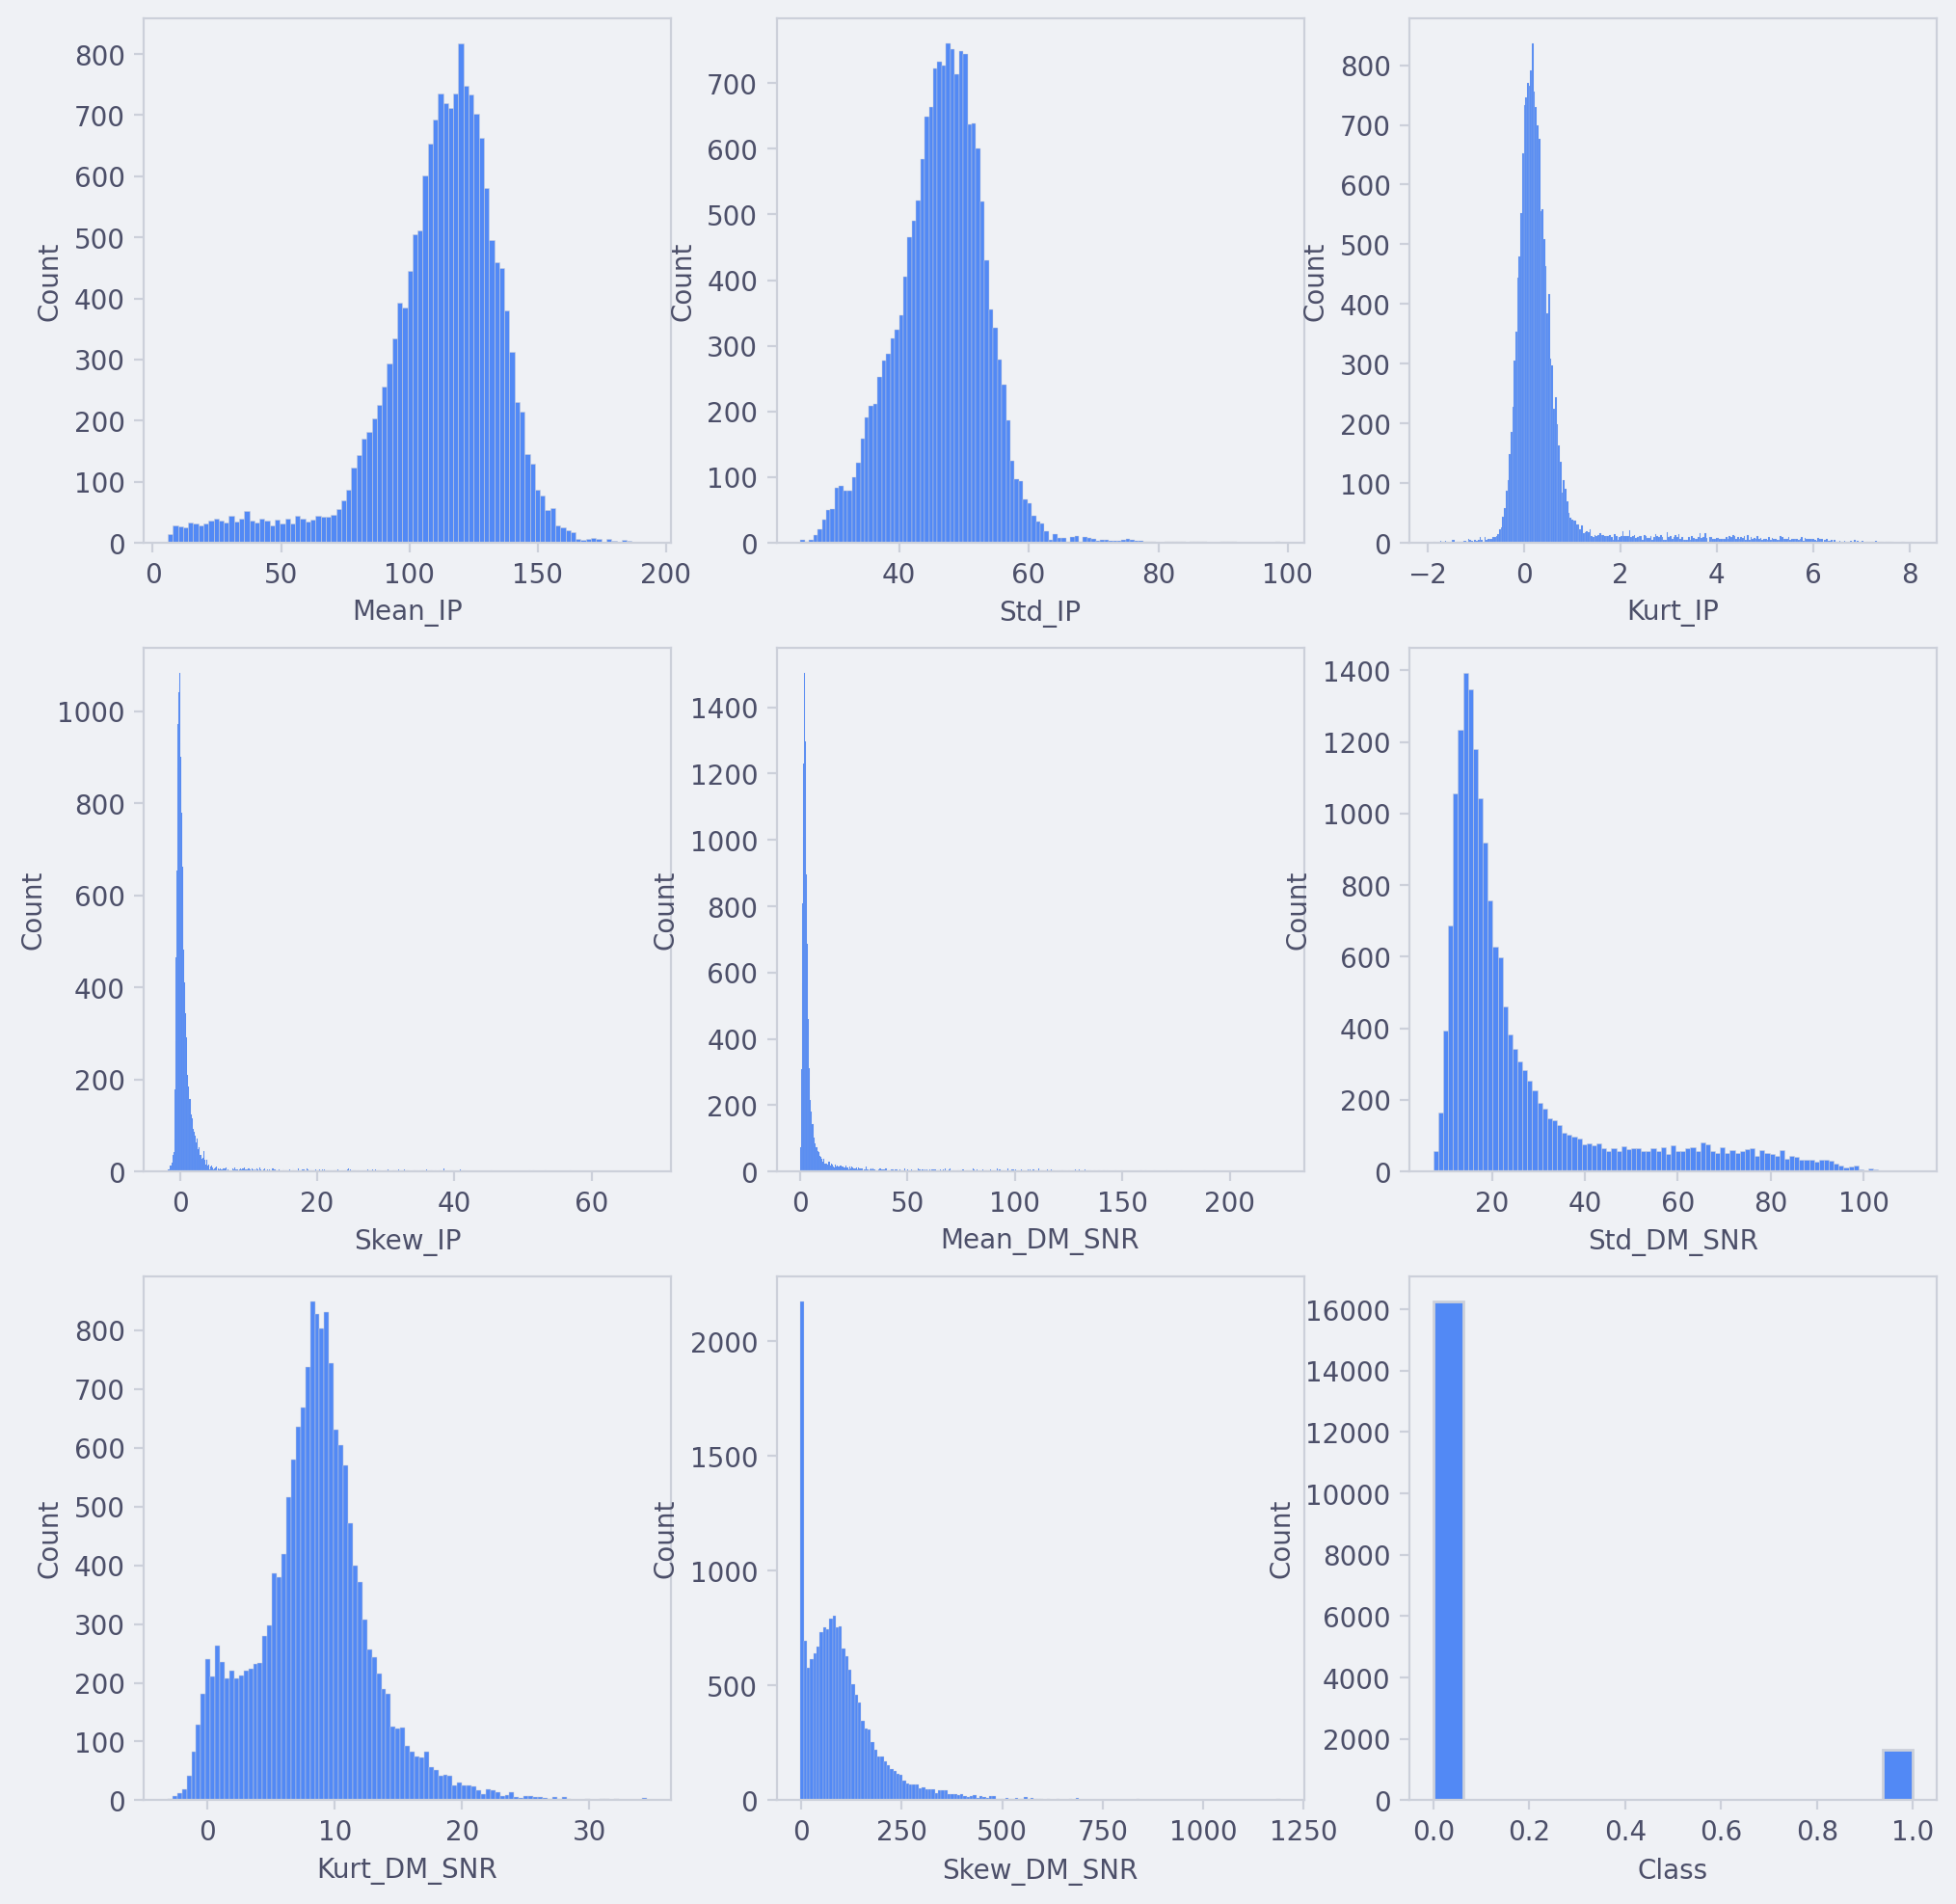

In [4]:
nrows=3
ncols=3

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
cols = pulsar_df.columns.to_list()

for _, k in enumerate(cols):
    ax = plt.subplot(nrows, ncols, _+1)
    sns.histplot(x=pulsar_df[k], ax=ax)

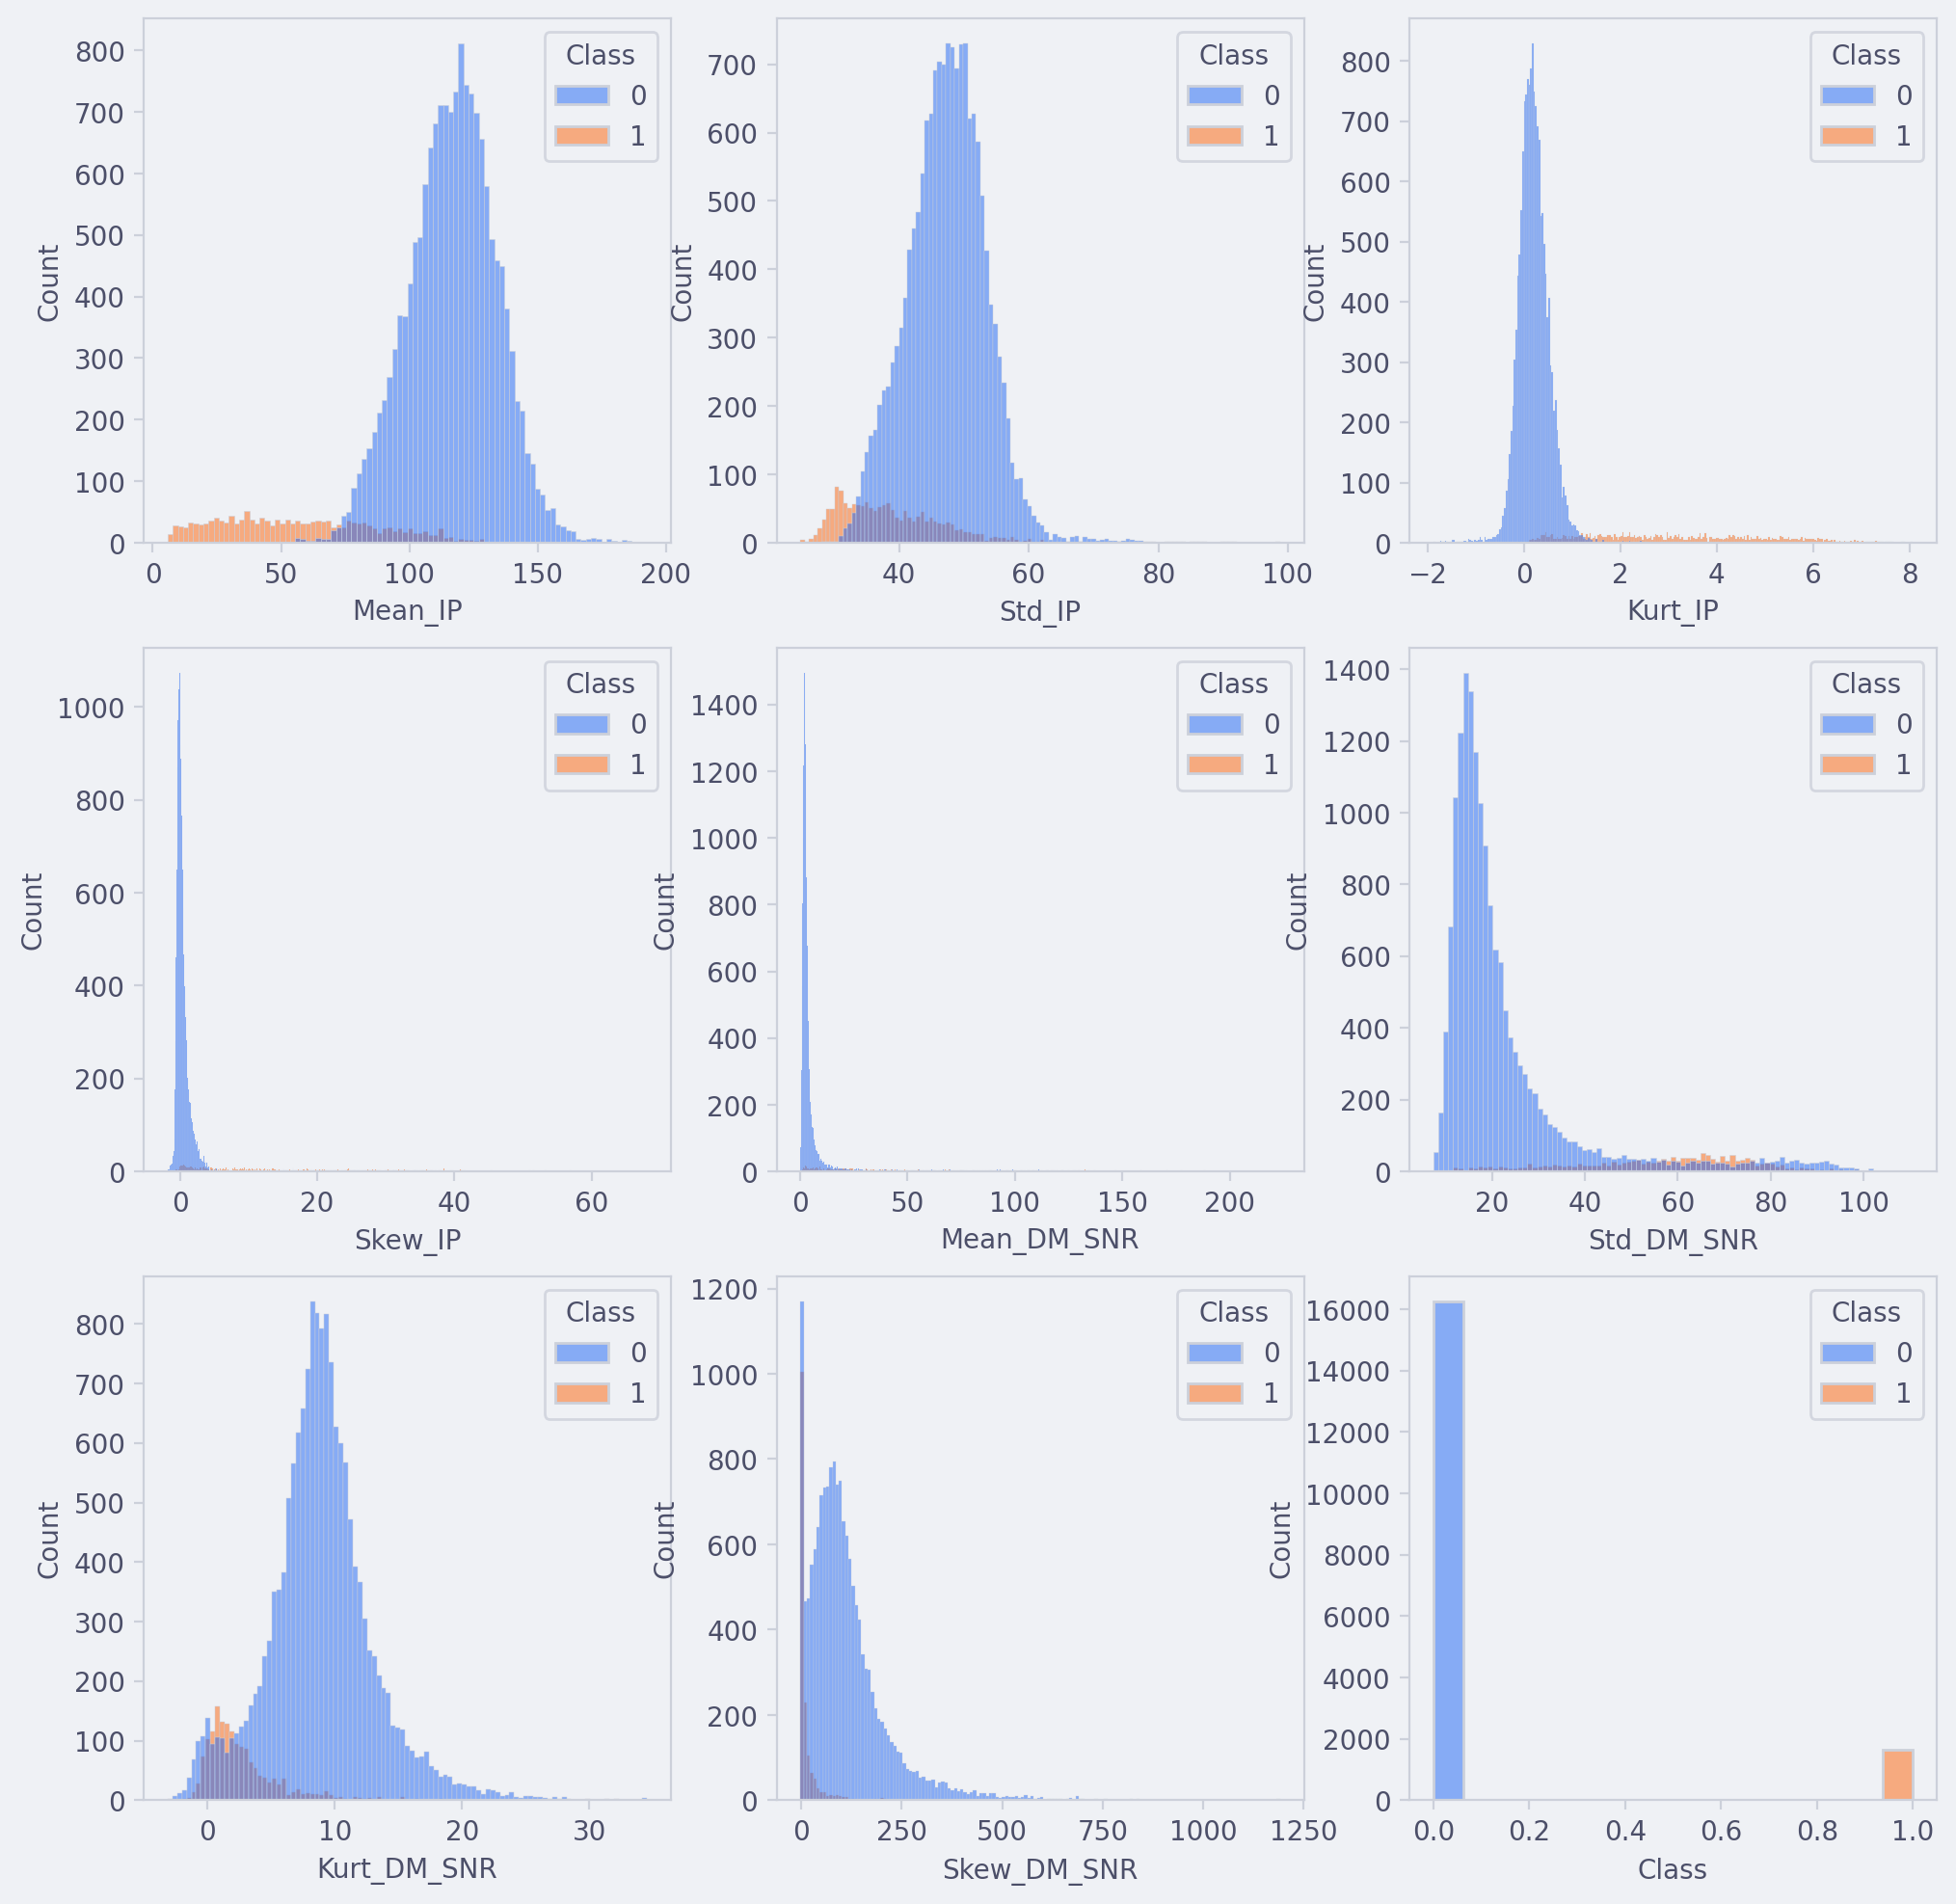

In [5]:
plt.figure(figsize=(12,12))
for _, k in enumerate(cols):
    ax = plt.subplot(nrows, ncols, _+1)
    sns.histplot(x=pulsar_df[k], ax=ax, hue=pulsar_df['Class'])

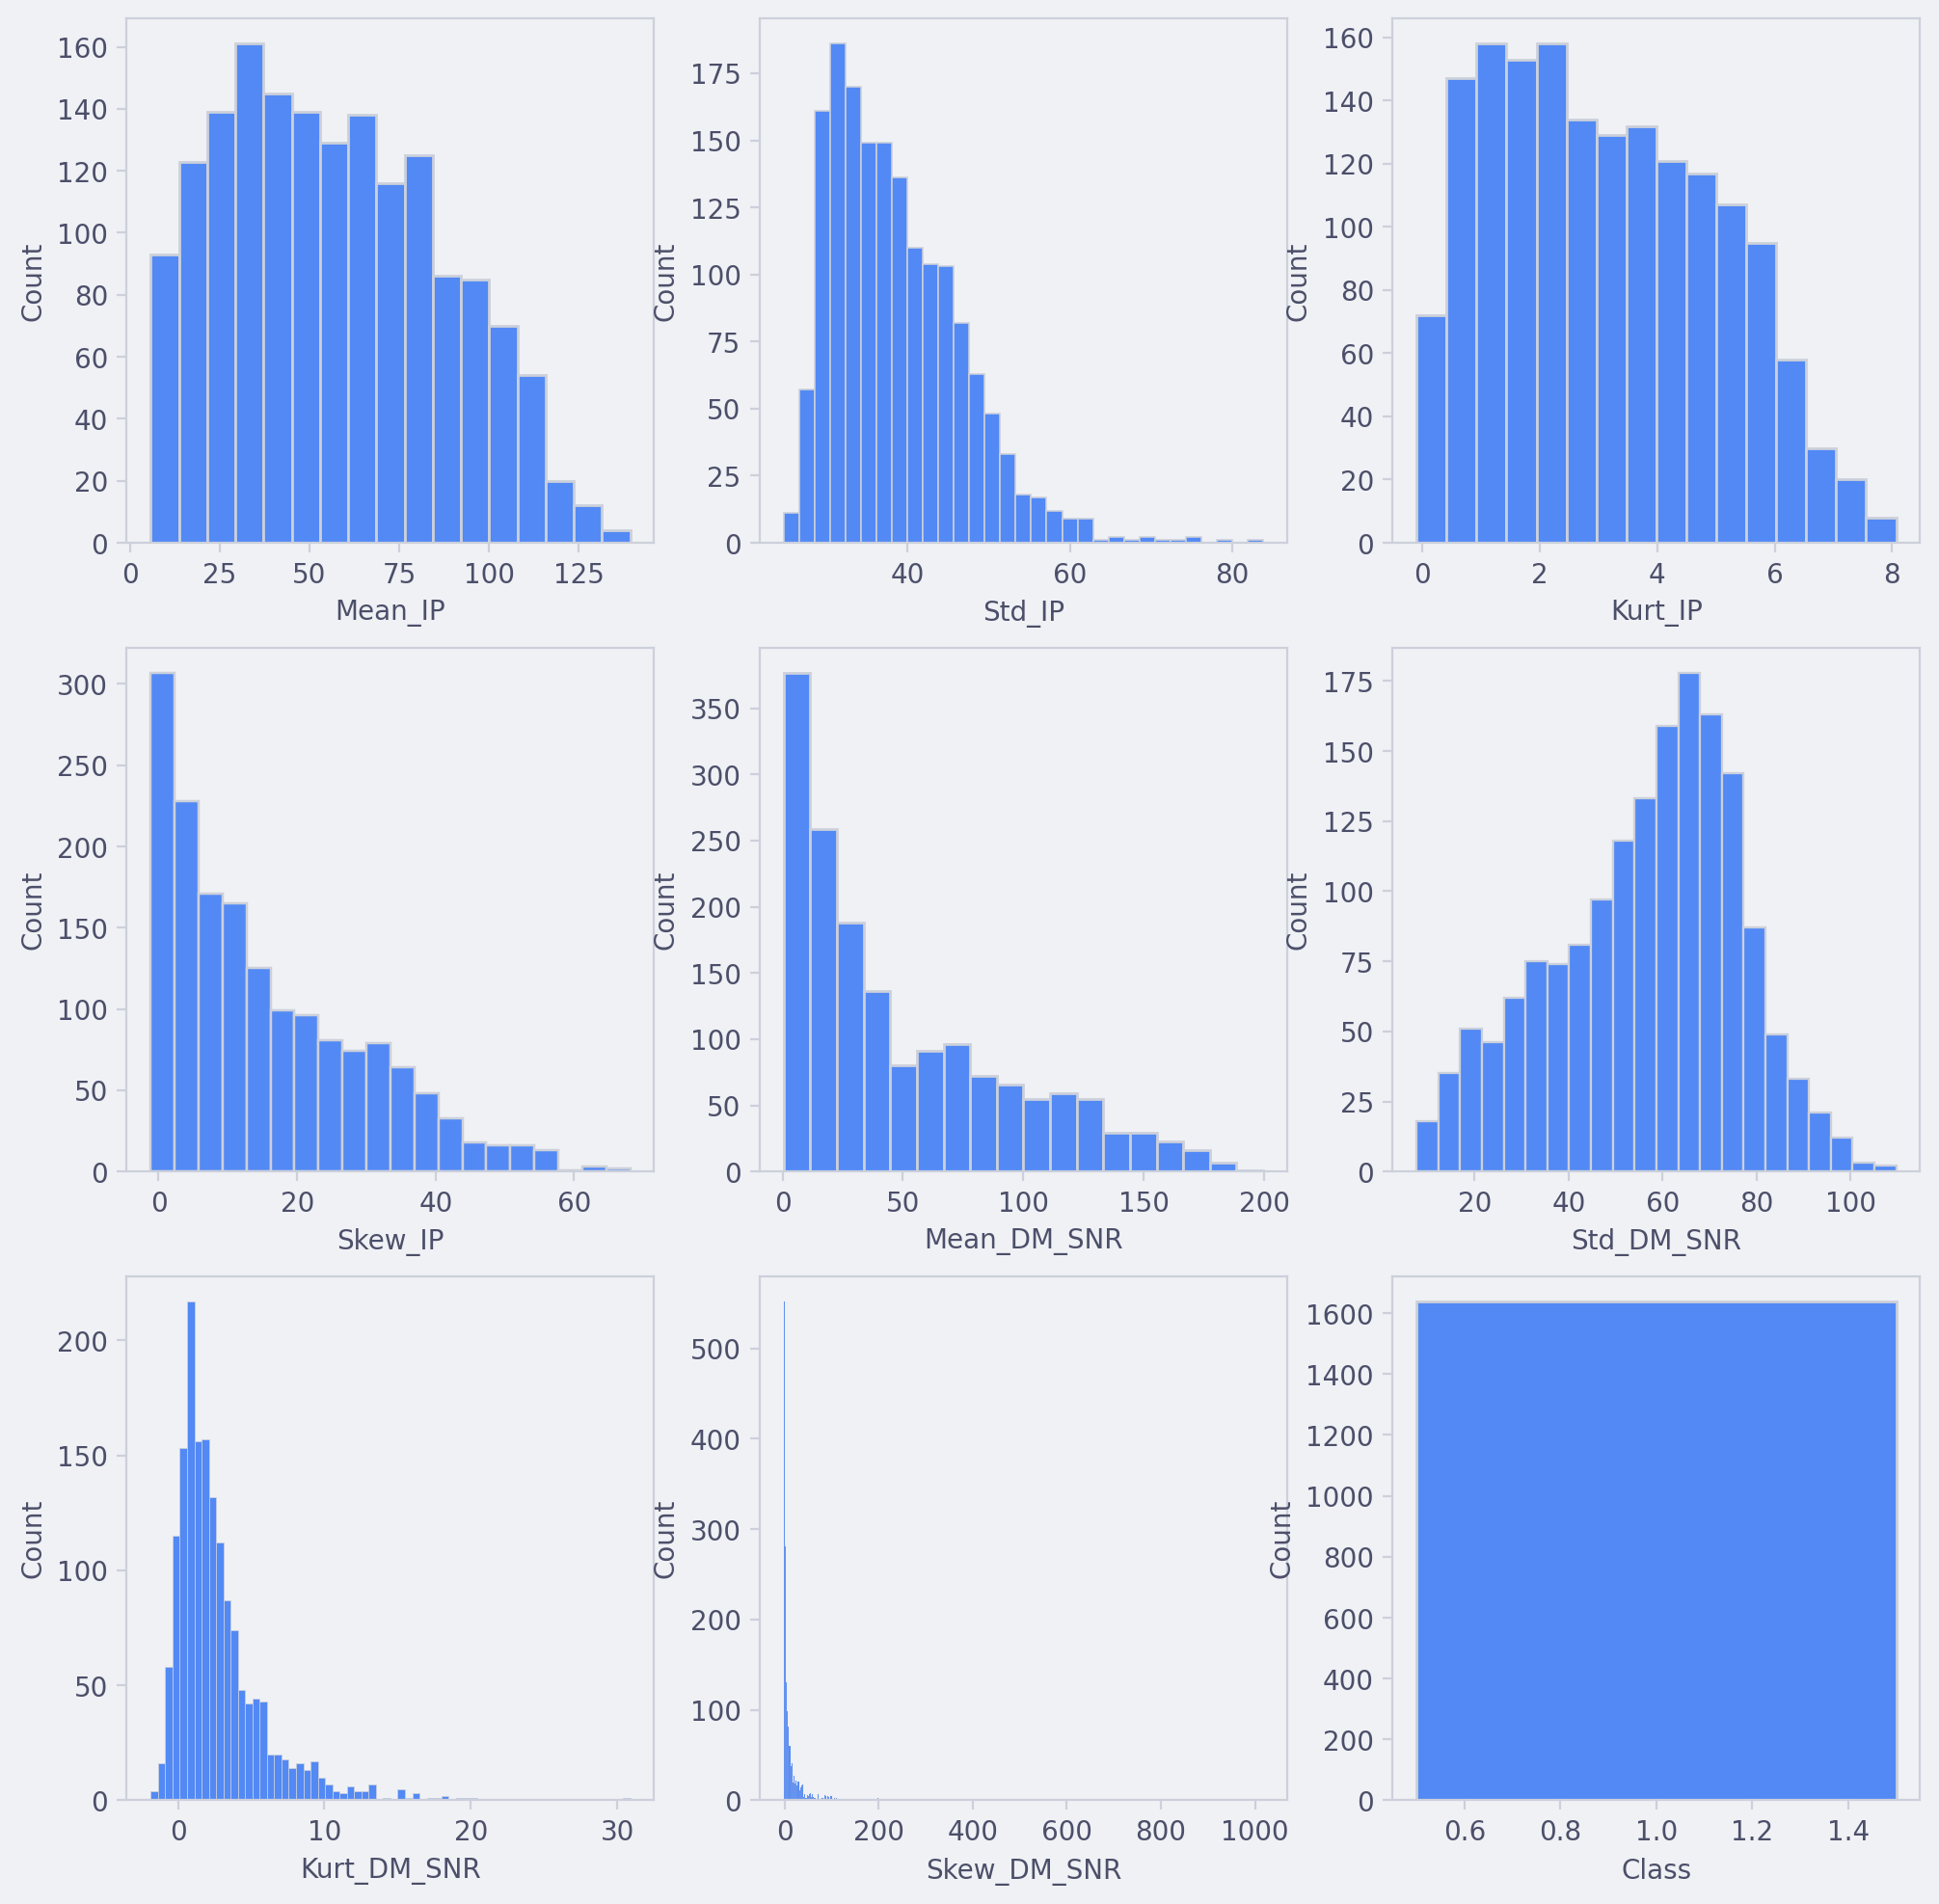

In [6]:
class_i = pulsar_df.loc[pulsar_df['Class']==1]
plt.figure(figsize=(12,12))
for _, k in enumerate(class_i.columns.to_list()):
    ax = plt.subplot(nrows, ncols, _+1)
    sns.histplot(x=class_i[k], ax=ax)

<Axes: xlabel='Class', ylabel='count'>

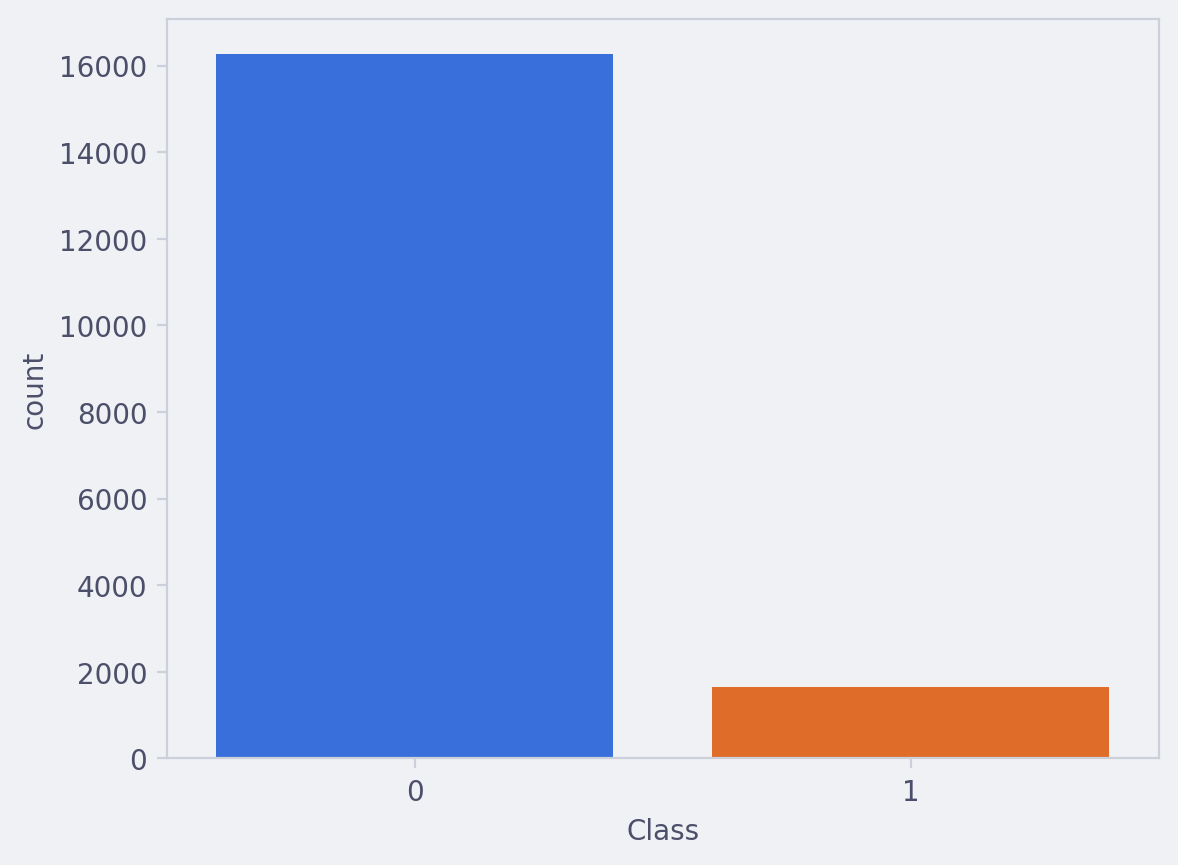

In [7]:
sns.countplot(data=pulsar_df, x='Class')

### Divide the original dataset in training and test, before doing a resampling as the data is way too much imbalanced

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pulsar_df, train_size=0.9, shuffle=True, stratify=pulsar_df['Class'])
print(train.shape)
print(test.shape)

(16108, 9)
(1790, 9)


### Oversample the training data

In [10]:
from imblearn.over_sampling import SMOTE

ros = SMOTE(sampling_strategy=0.6, n_jobs=-1)
X = train.drop('Class', axis=1)
y = train['Class']

X_resample, y_resample = ros.fit_resample(X,y)

from collections import Counter
print(sorted(Counter(y_resample).items()))

[(0, 14633), (1, 8779)]


/Users/alejandrodelgado/kaggle_2/new_env/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [11]:
df_pulsar = pd.concat([X_resample, y_resample], axis=1)
df_pulsar.head()

,Mean_IP,Std_IP,Kurt_IP,Skew_IP,Mean_DM_SNR,Std_DM_SNR,Kurt_DM_SNR,Skew_DM_SNR,Class
0,113.250000,49.828769,0.322661,0.084225,2.450669,15.077672,9.948781,129.623222,0
1,127.218750,52.829315,0.002670,-0.340639,4.744983,29.022815,6.745575,46.328877,0
2,91.640625,44.113974,0.225167,0.608736,1.149666,12.850250,12.943666,190.646586,0
3,135.898438,50.390016,-0.067826,-0.383874,4.194816,20.403857,6.780407,56.316195,0
4,104.171875,42.572568,0.444381,1.250158,3.418896,21.036064,7.396831,60.681938,1


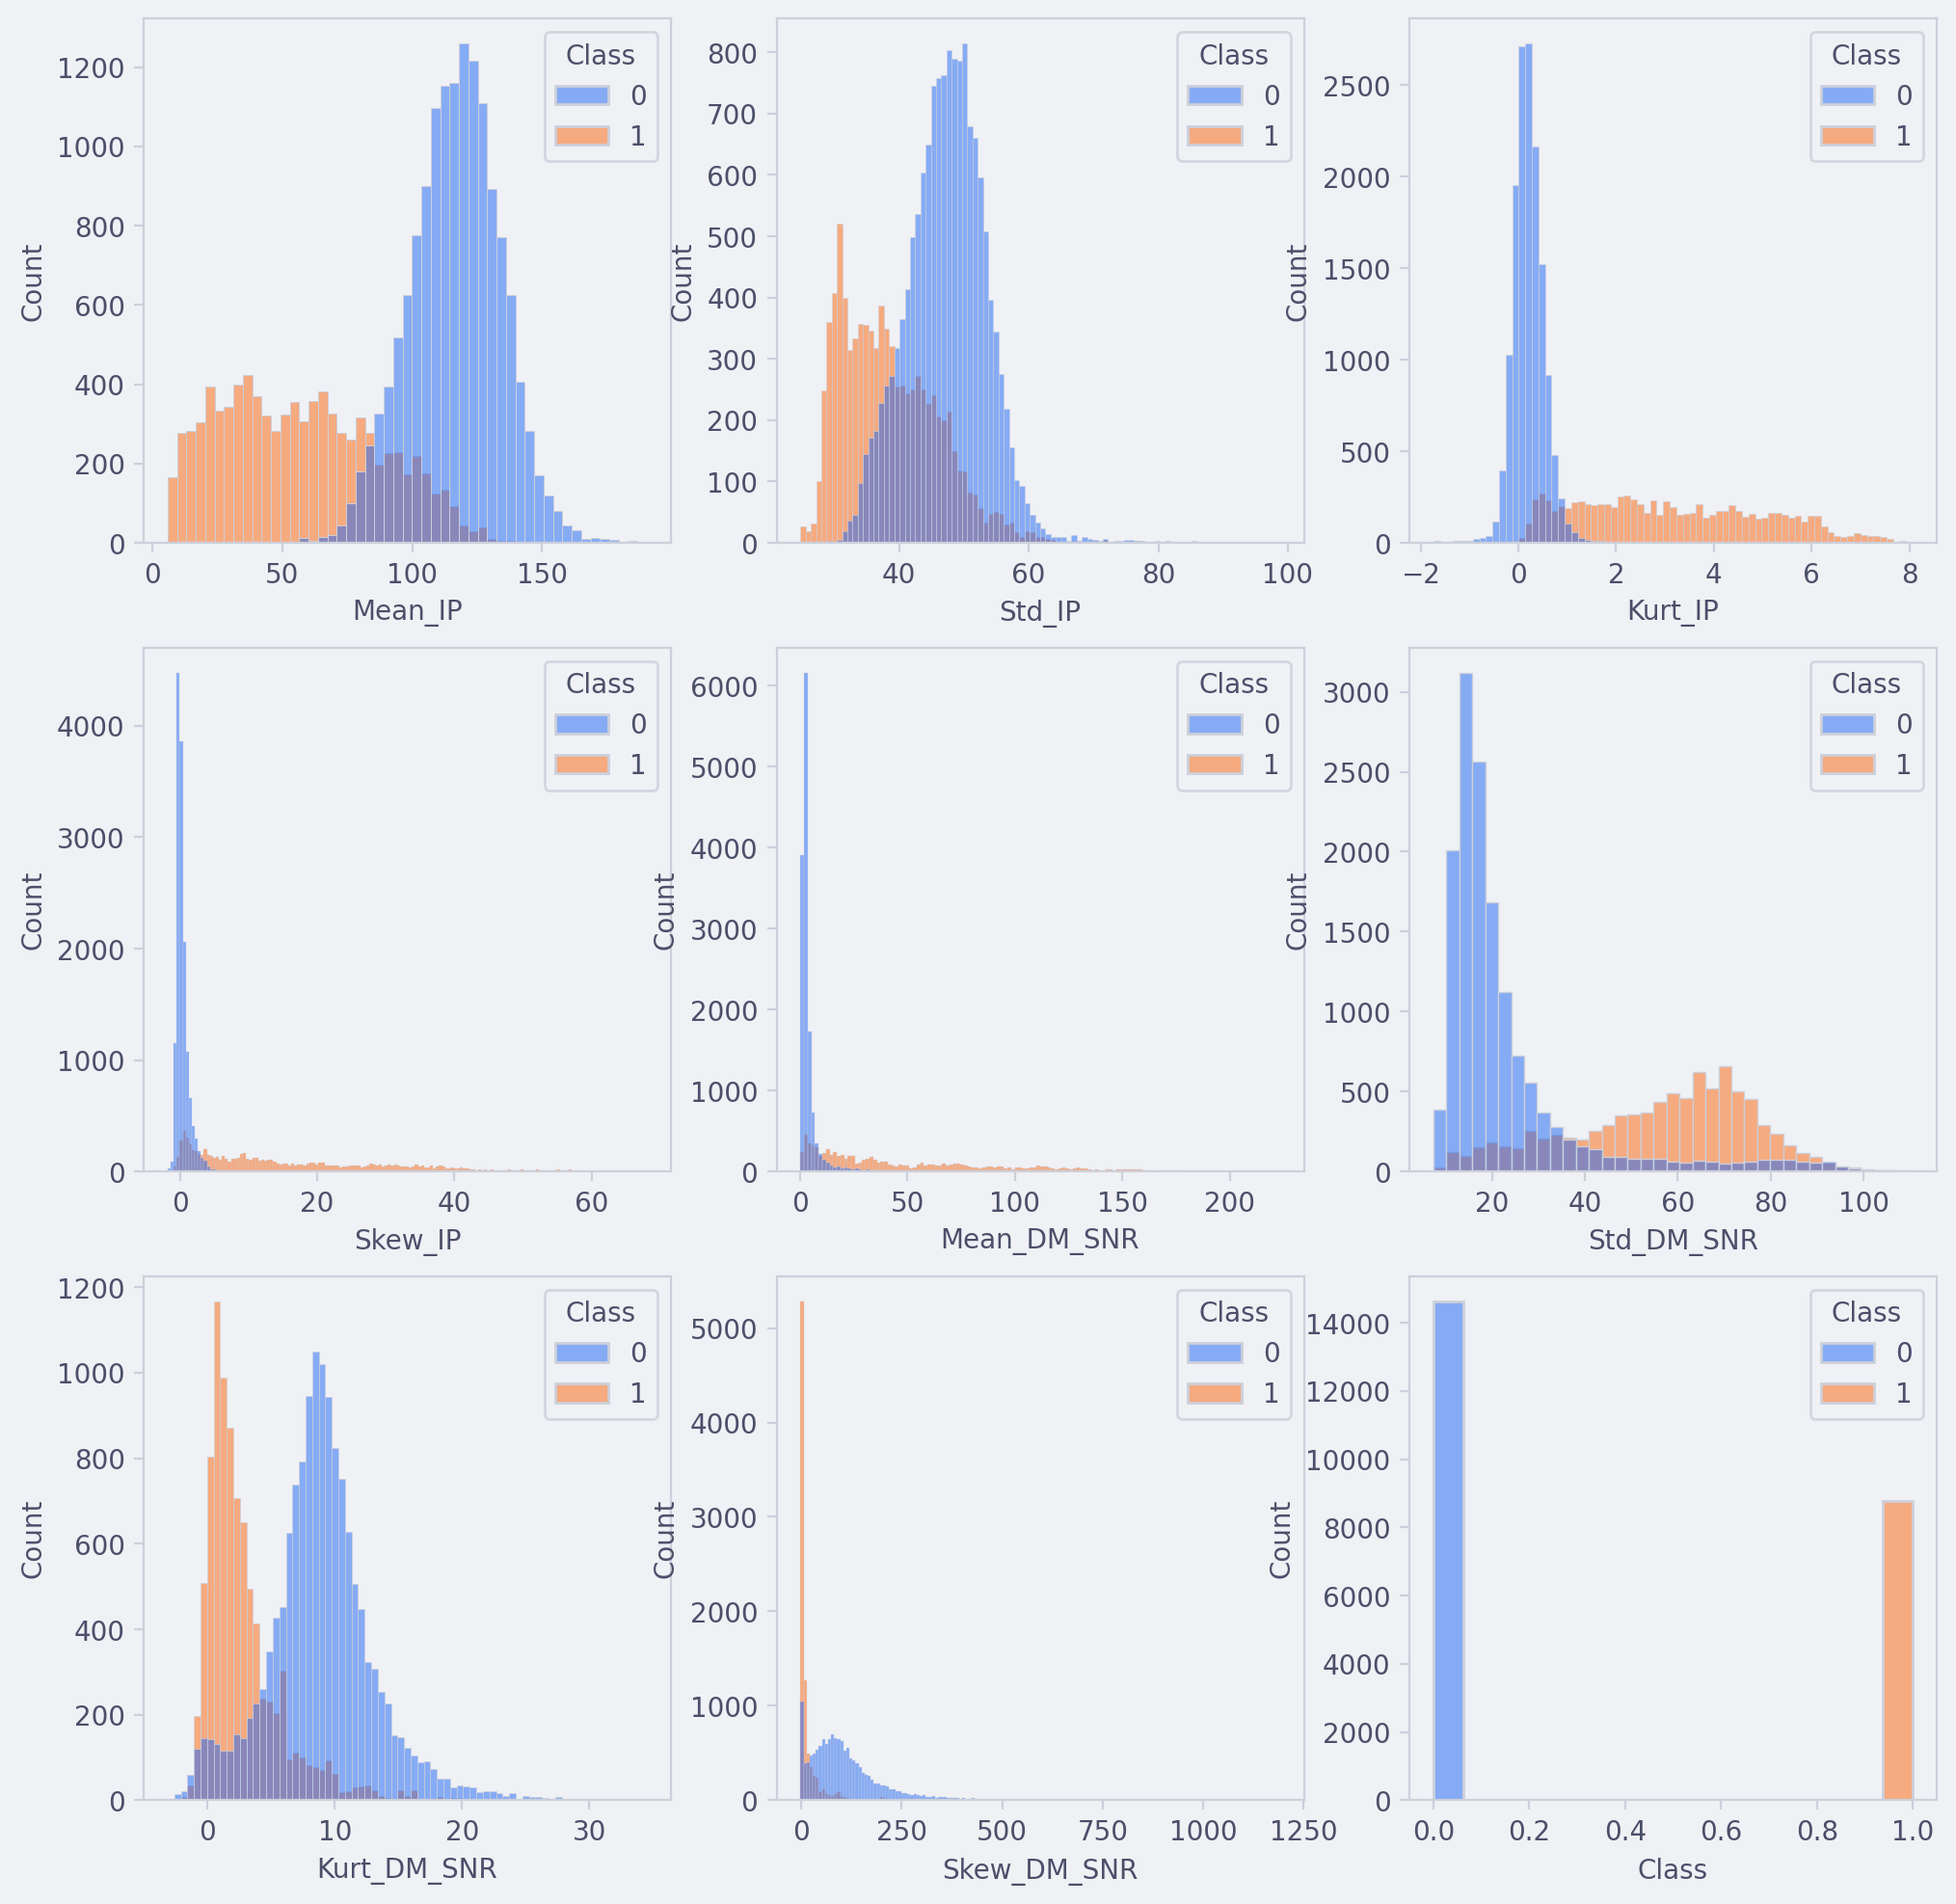

In [12]:
plt.figure(figsize=(12,12))
for _, k in enumerate(df_pulsar.columns.to_list()):
    ax = plt.subplot(nrows, ncols, _+1)
    sns.histplot(x=df_pulsar[k], ax=ax, hue=df_pulsar['Class'])

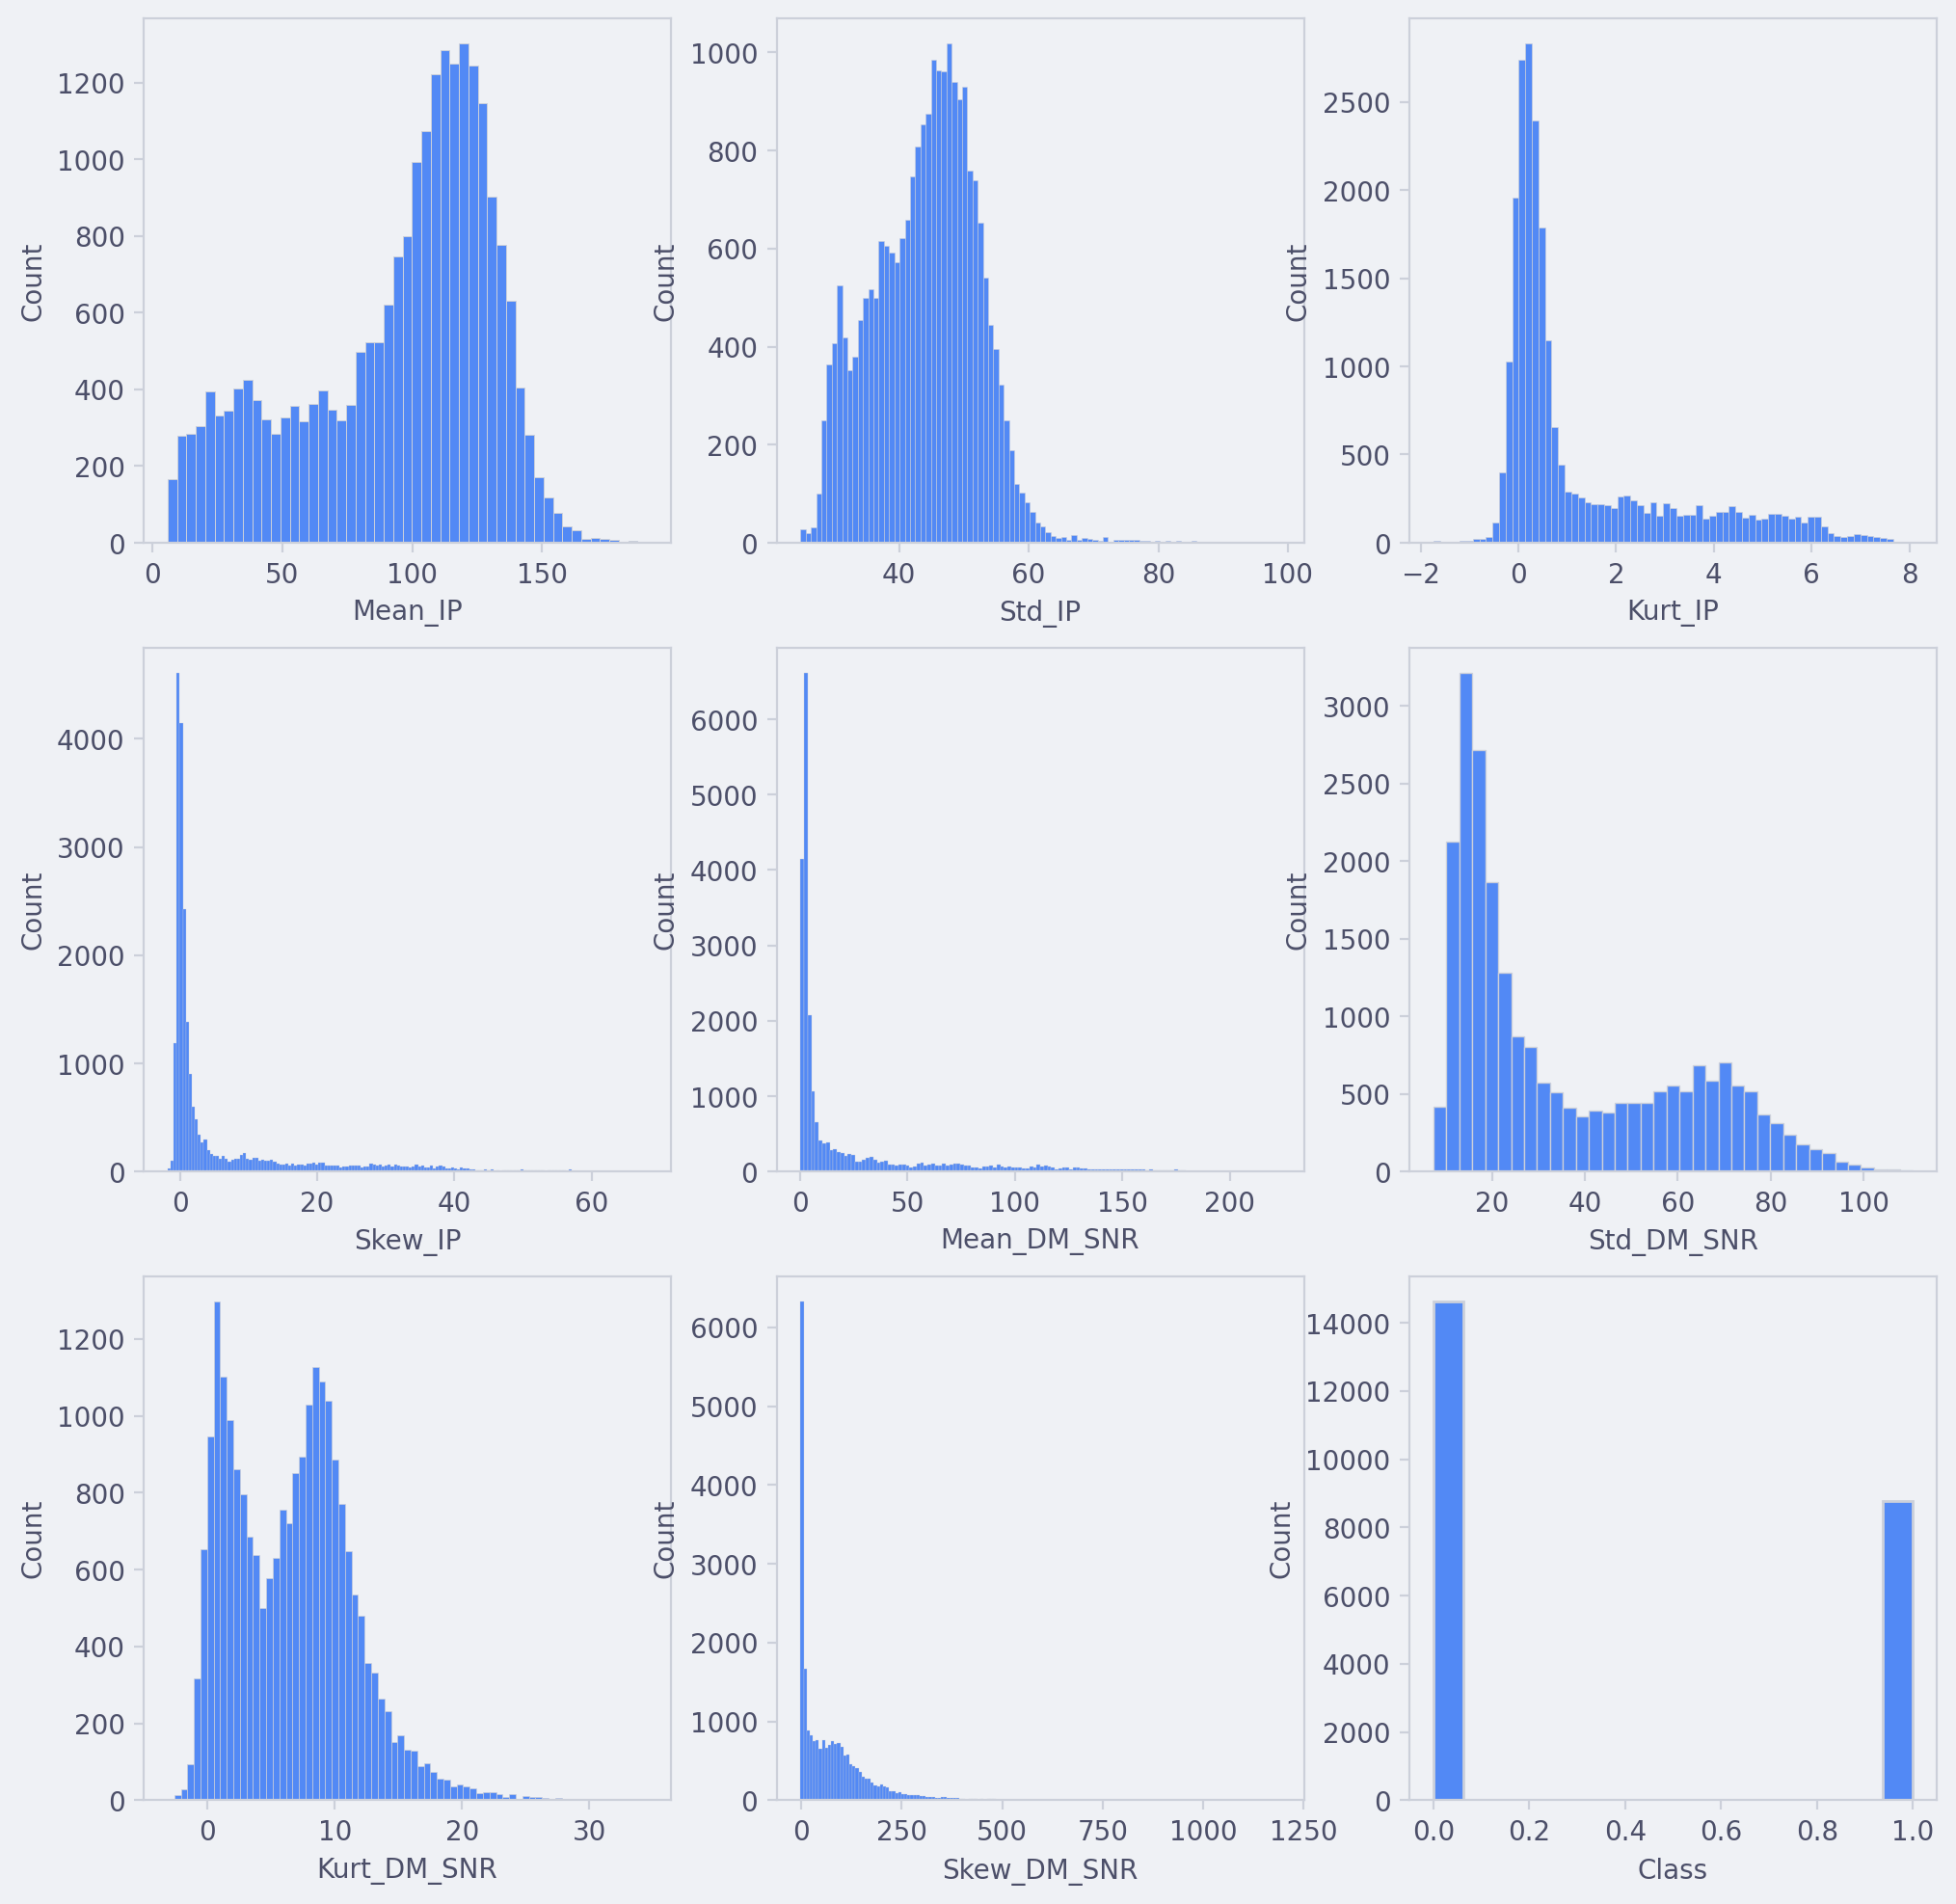

In [13]:
plt.figure(figsize=(12,12))
for _, k in enumerate(df_pulsar.columns.to_list()):
    ax = plt.subplot(nrows, ncols, _+1)
    sns.histplot(x=df_pulsar[k], ax=ax)

### Data Preprocessing

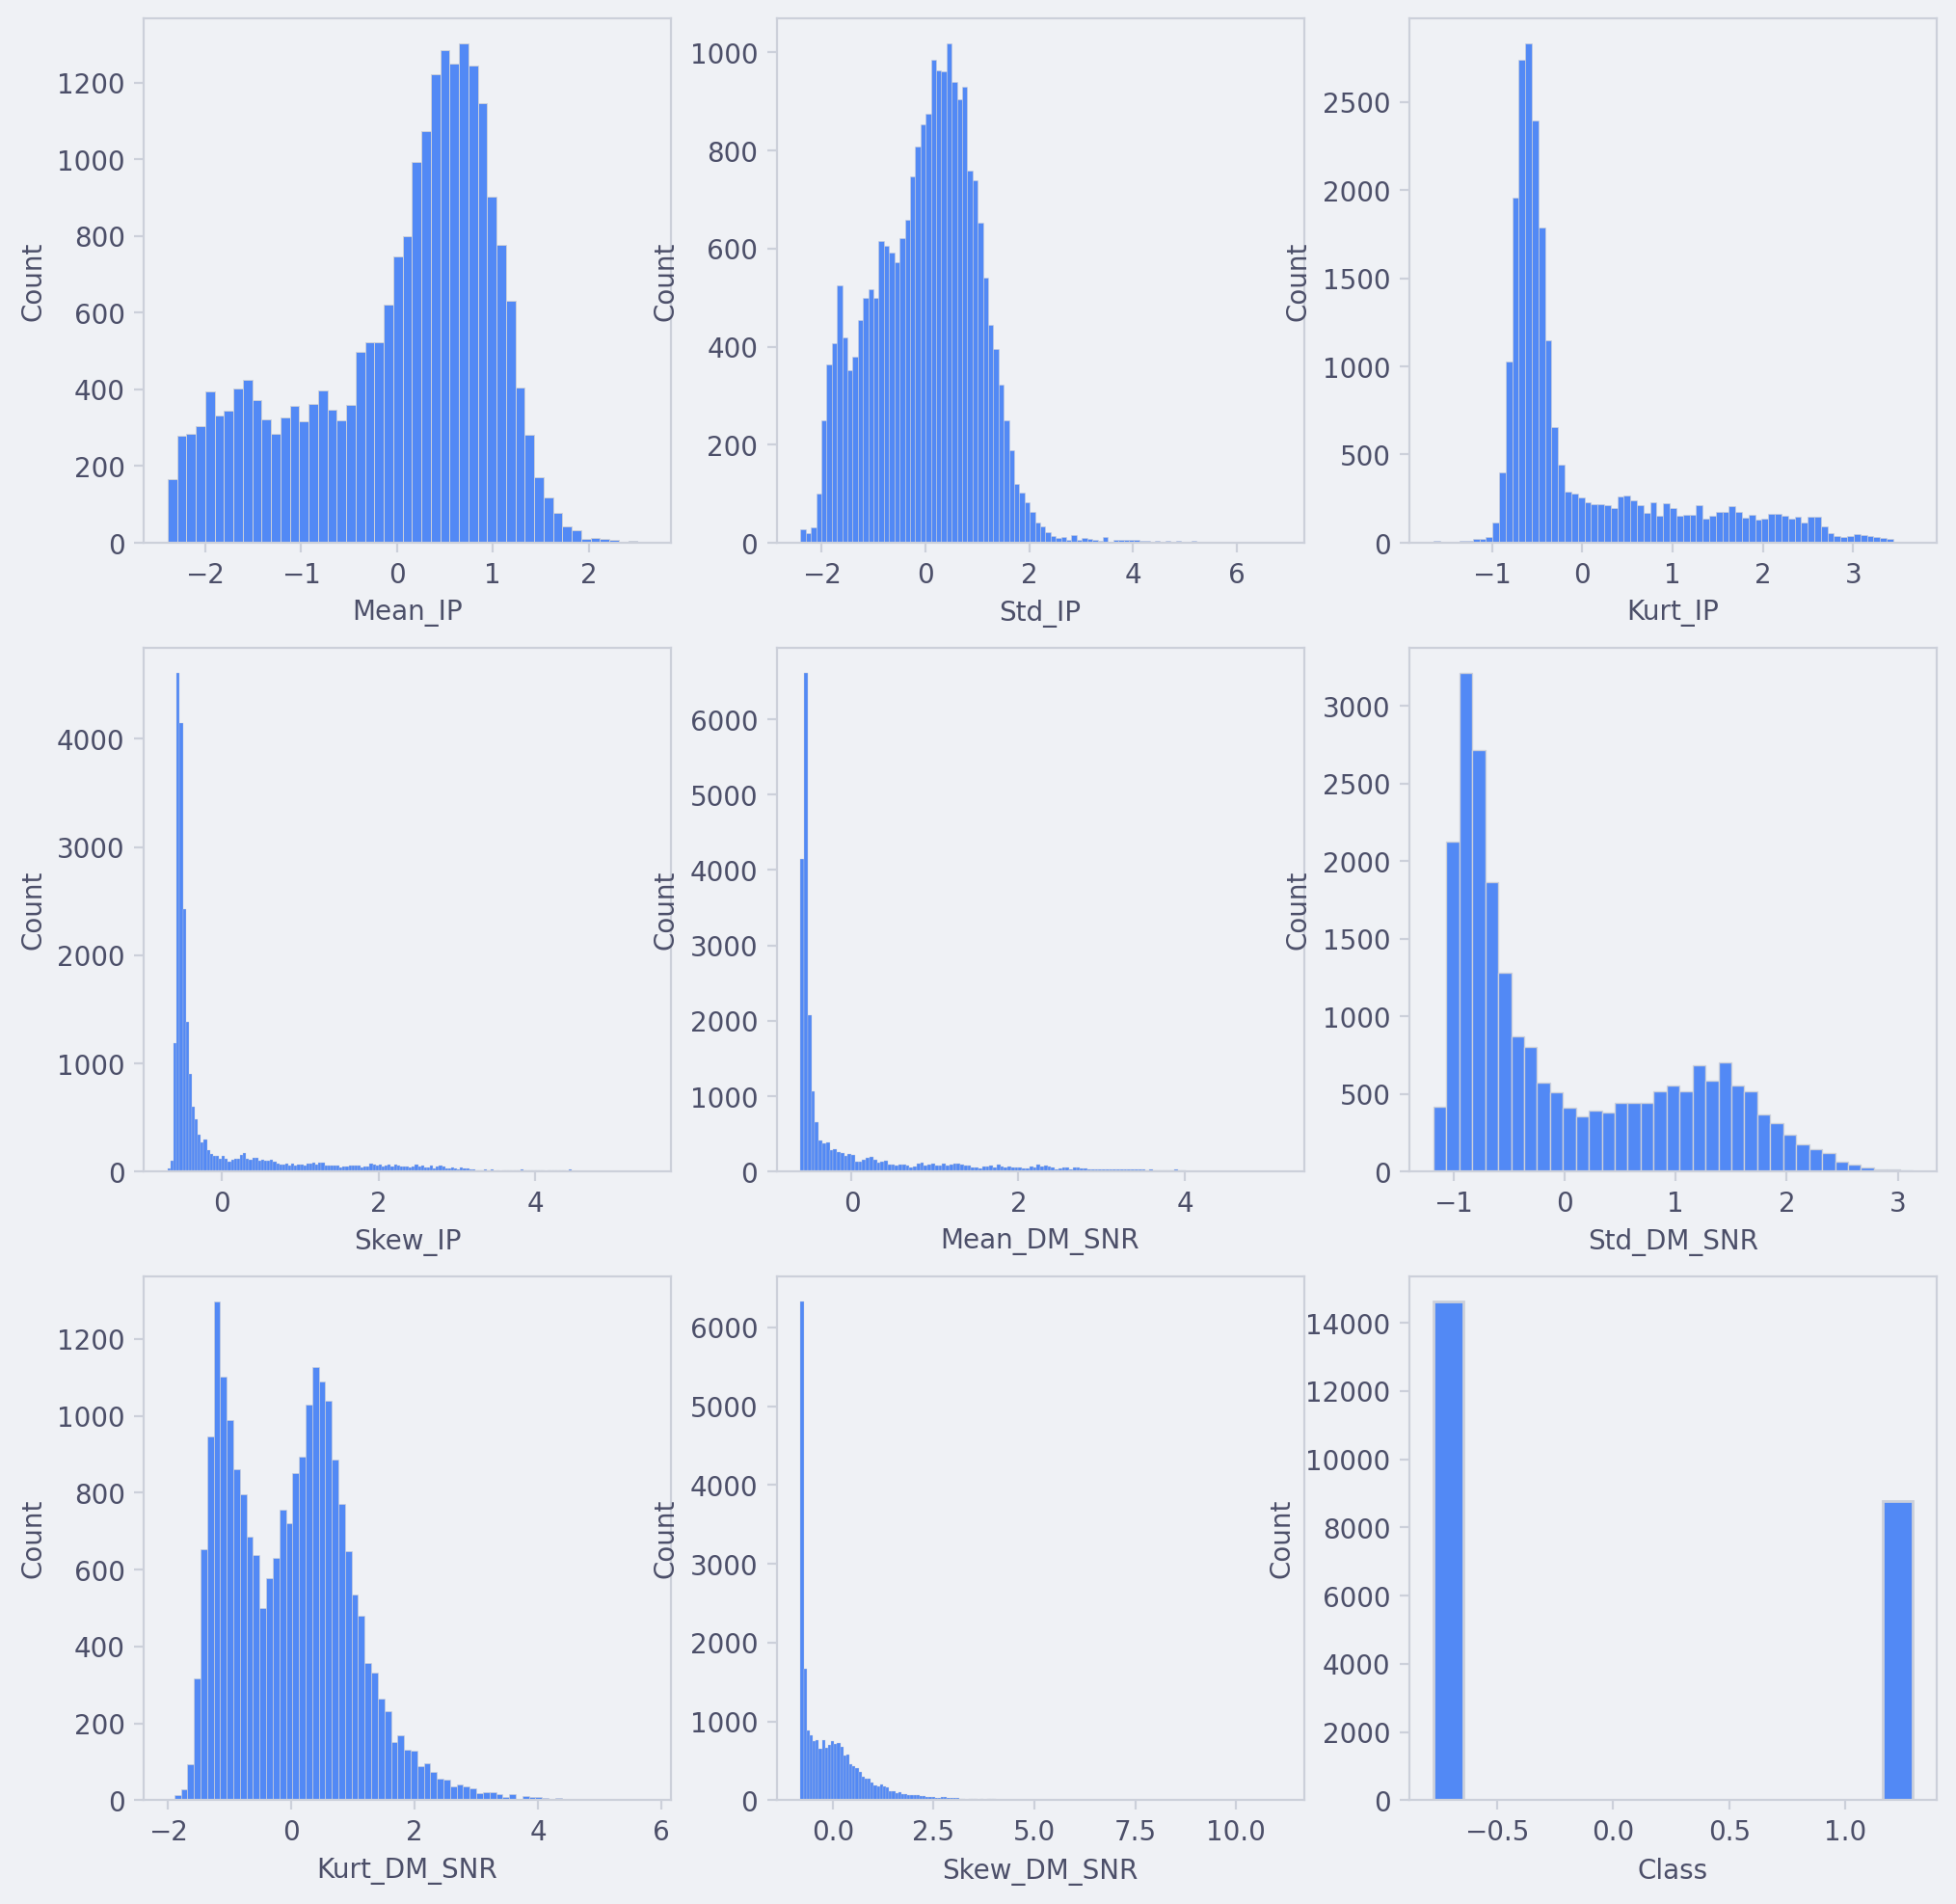

In [31]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, Normalizer, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

log_transf = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, check_inverse=False, feature_names_out='one-to-one')

std_transf = StandardScaler()
norm_transf = Normalizer()
minmax_transf = MinMaxScaler()
pow_transf = PowerTransformer()

test_check = pd.DataFrame(data=std_transf.fit_transform(df_pulsar), columns=df_pulsar.columns)

plt.figure(figsize=(12,12))
for _, k in enumerate(test_check.columns.to_list()):
    ax = plt.subplot(nrows, ncols, _+1)
    sns.histplot(x=test_check[k], ax=ax)

/Users/alejandrodelgado/kaggle_2/new_env/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


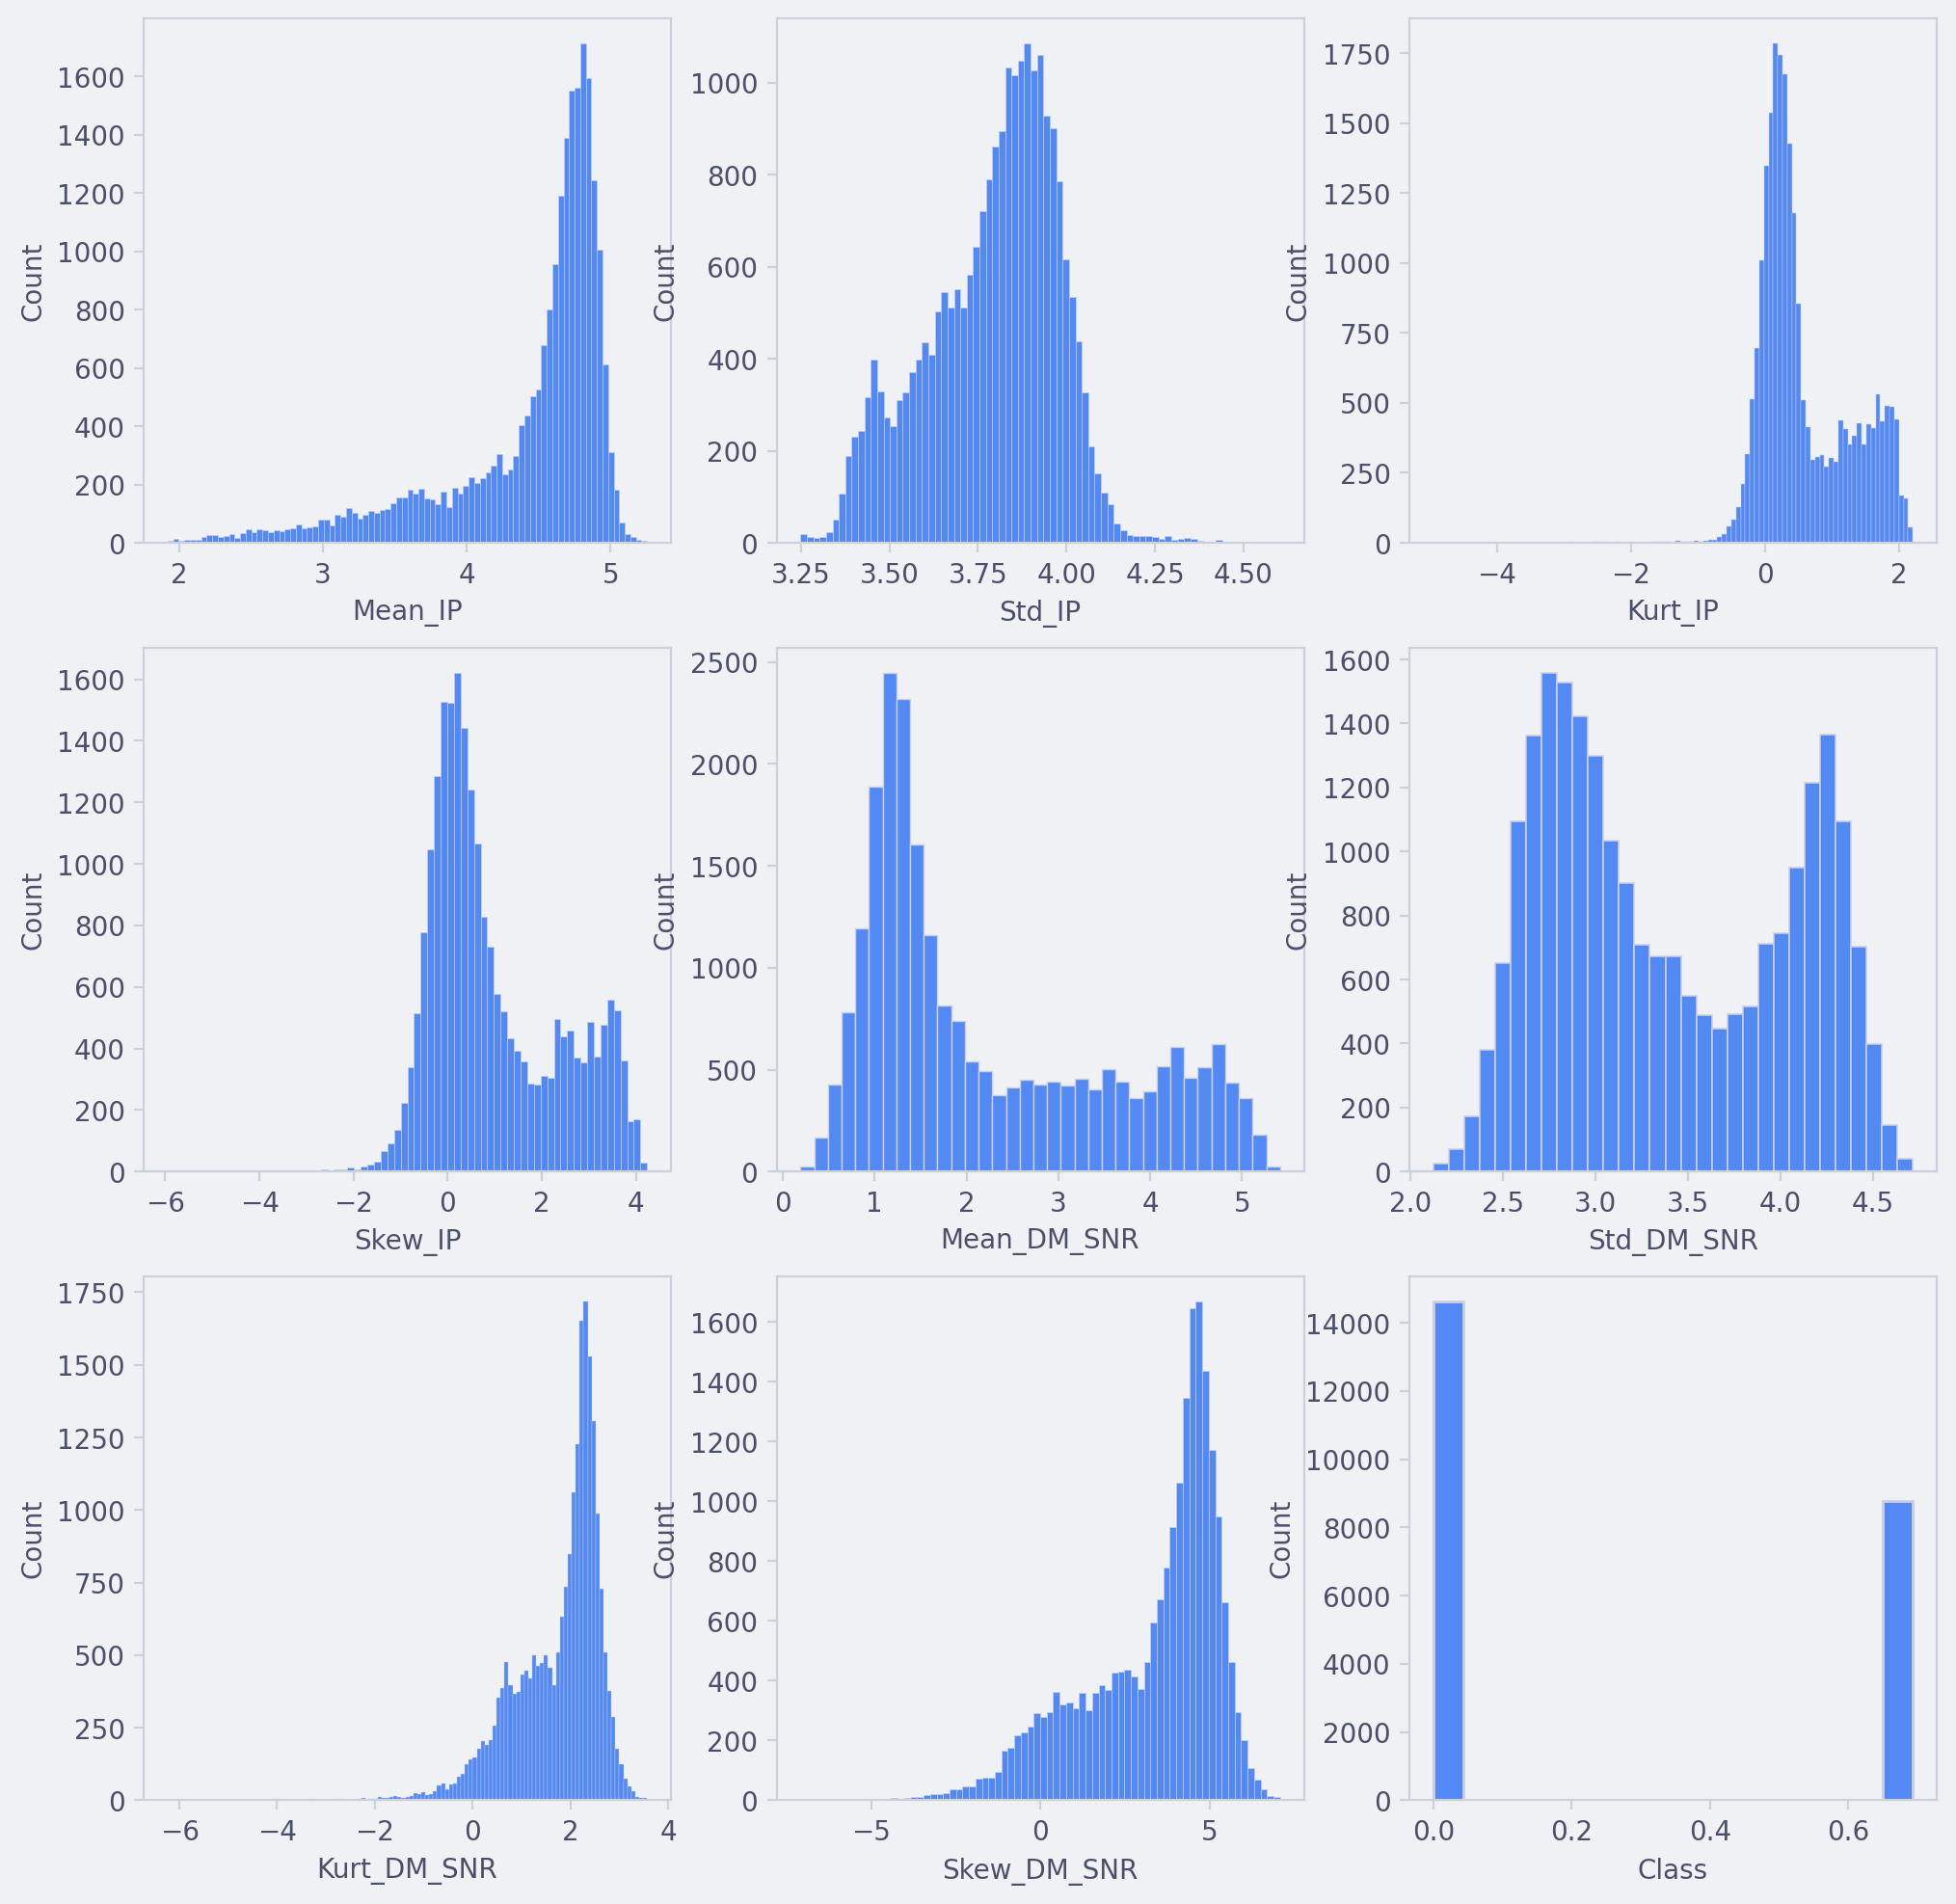

In [24]:
test_check = pd.DataFrame(data=log_transf.fit_transform(df_pulsar), columns=df_pulsar.columns)

plt.figure(figsize=(12,12))
for _, k in enumerate(test_check.columns.to_list()):
    ax = plt.subplot(nrows, ncols, _+1)
    sns.histplot(x=test_check[k], ax=ax)

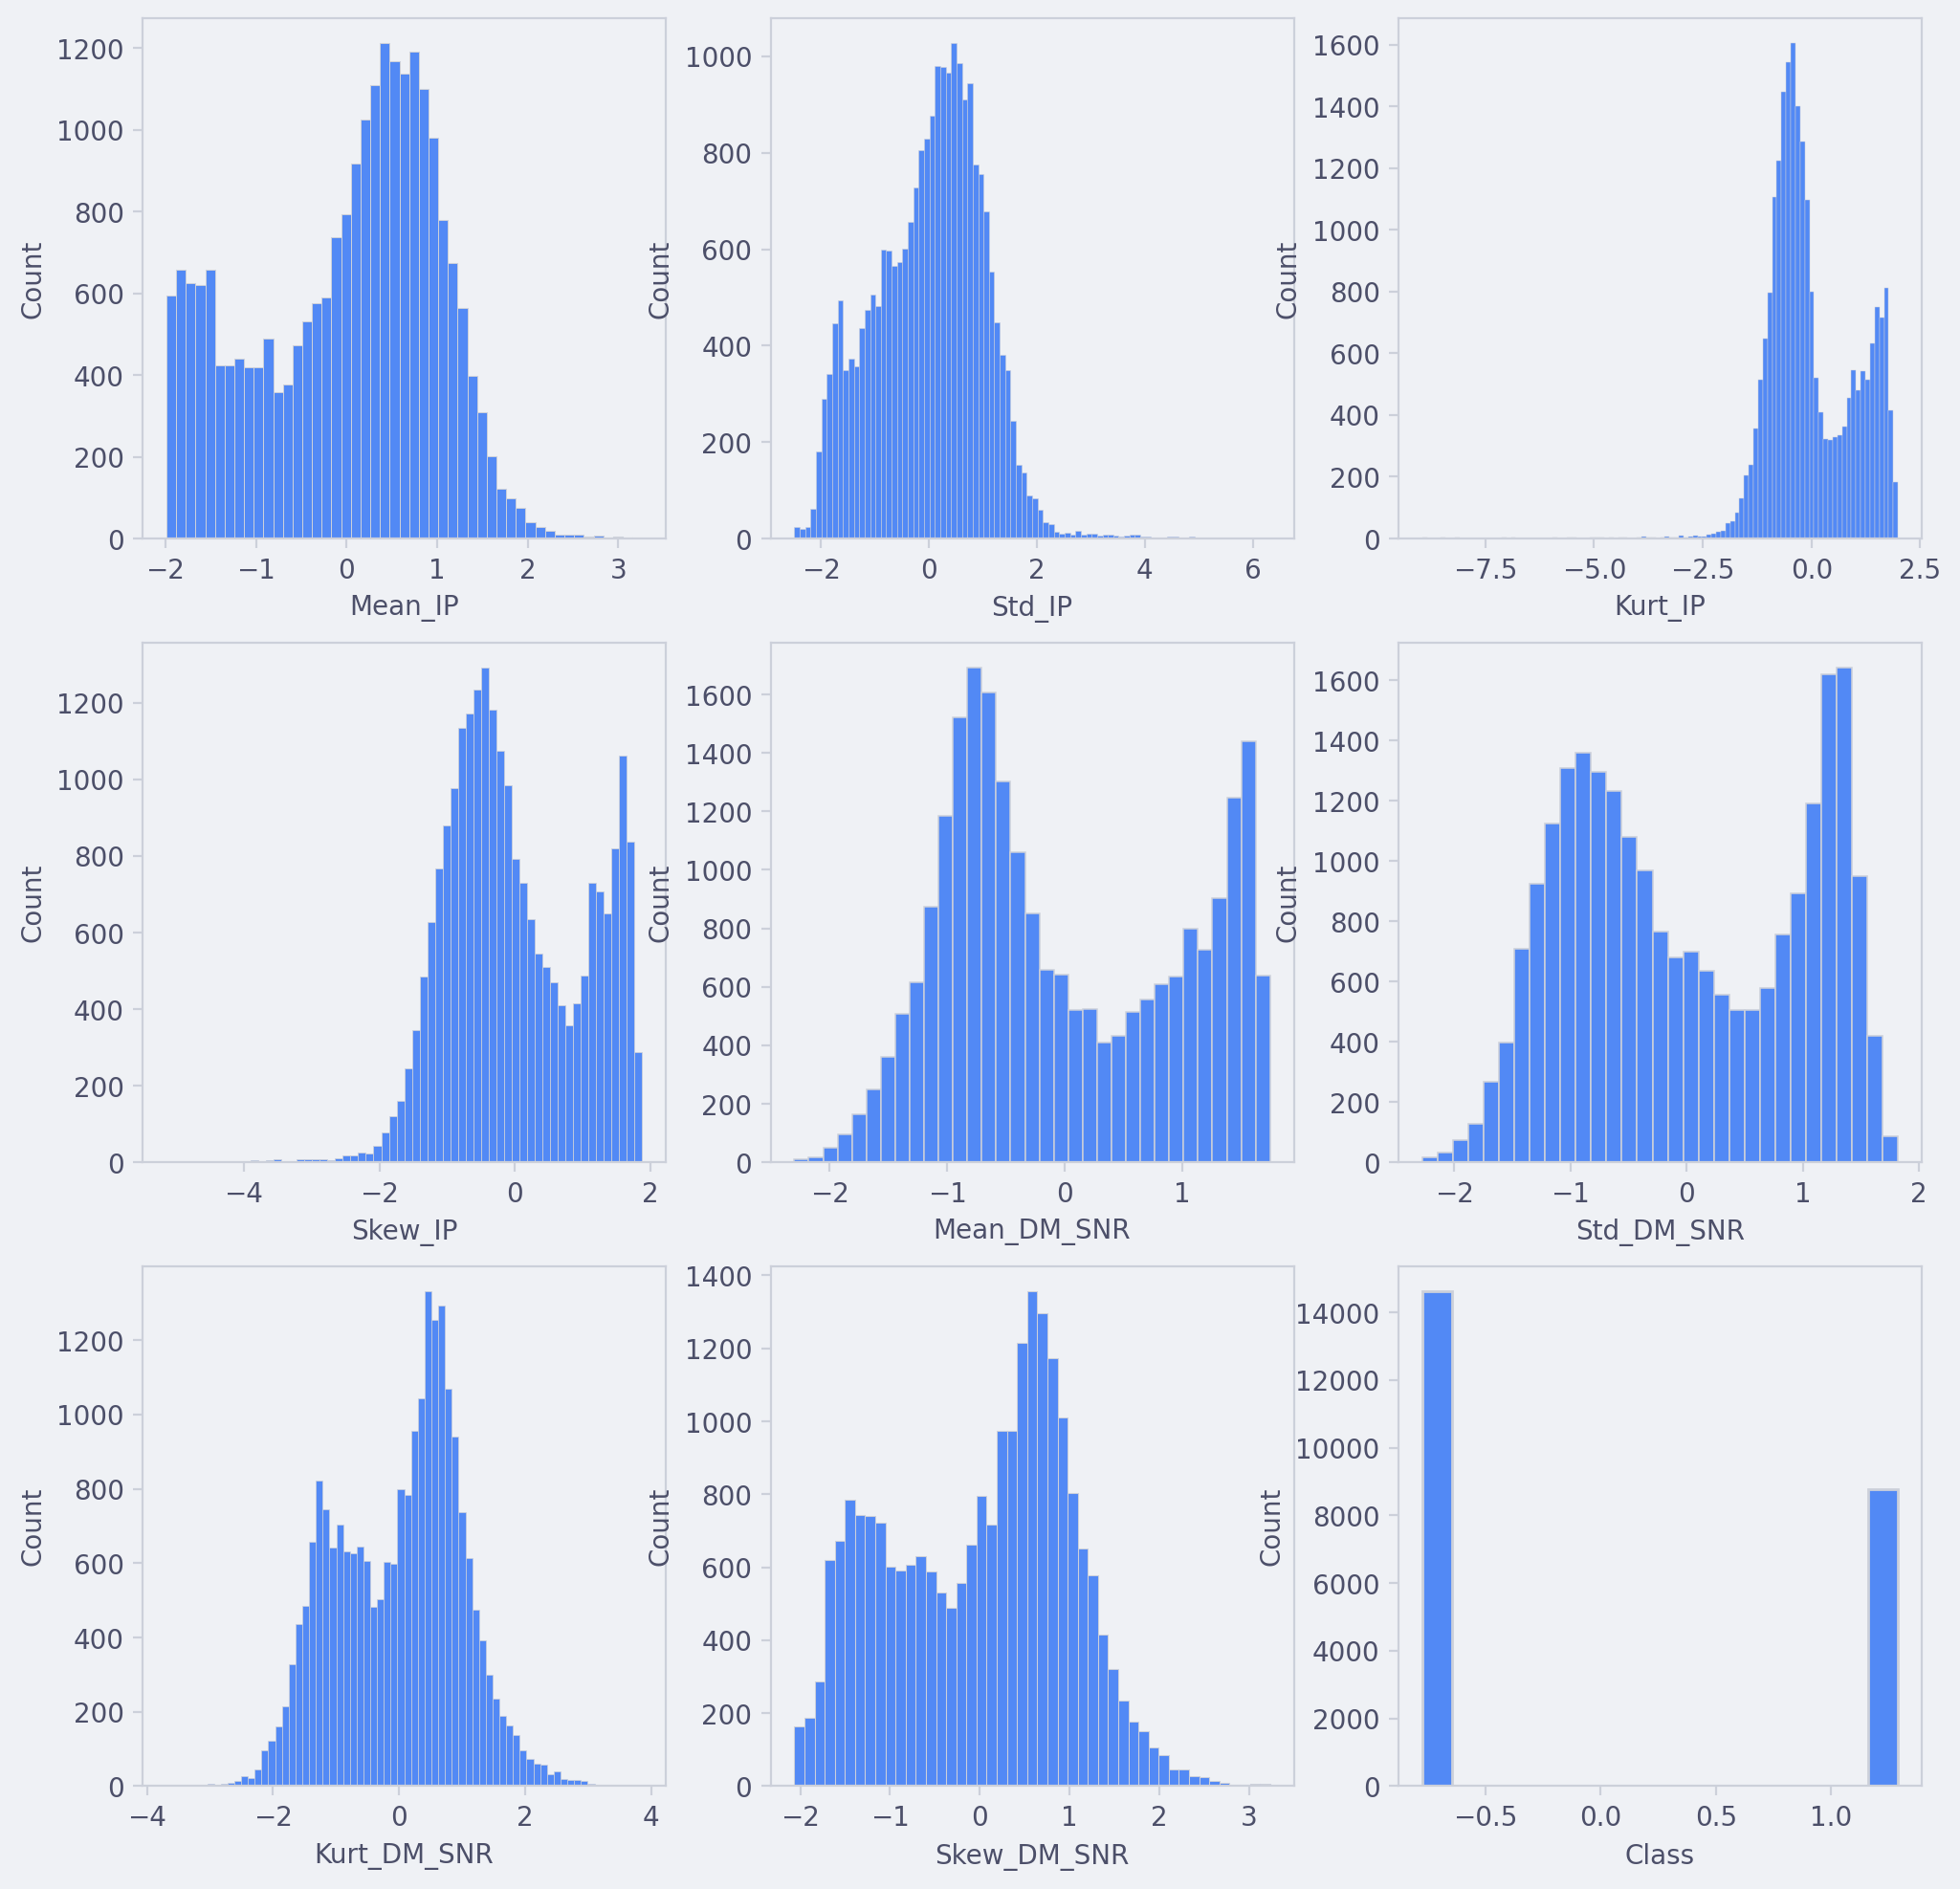

In [33]:
test_check = pd.DataFrame(data=pow_transf.fit_transform(df_pulsar), columns=df_pulsar.columns)

plt.figure(figsize=(12,12))
for _, k in enumerate(test_check.columns.to_list()):
    ax = plt.subplot(nrows, ncols, _+1)
    sns.histplot(x=test_check[k], ax=ax)

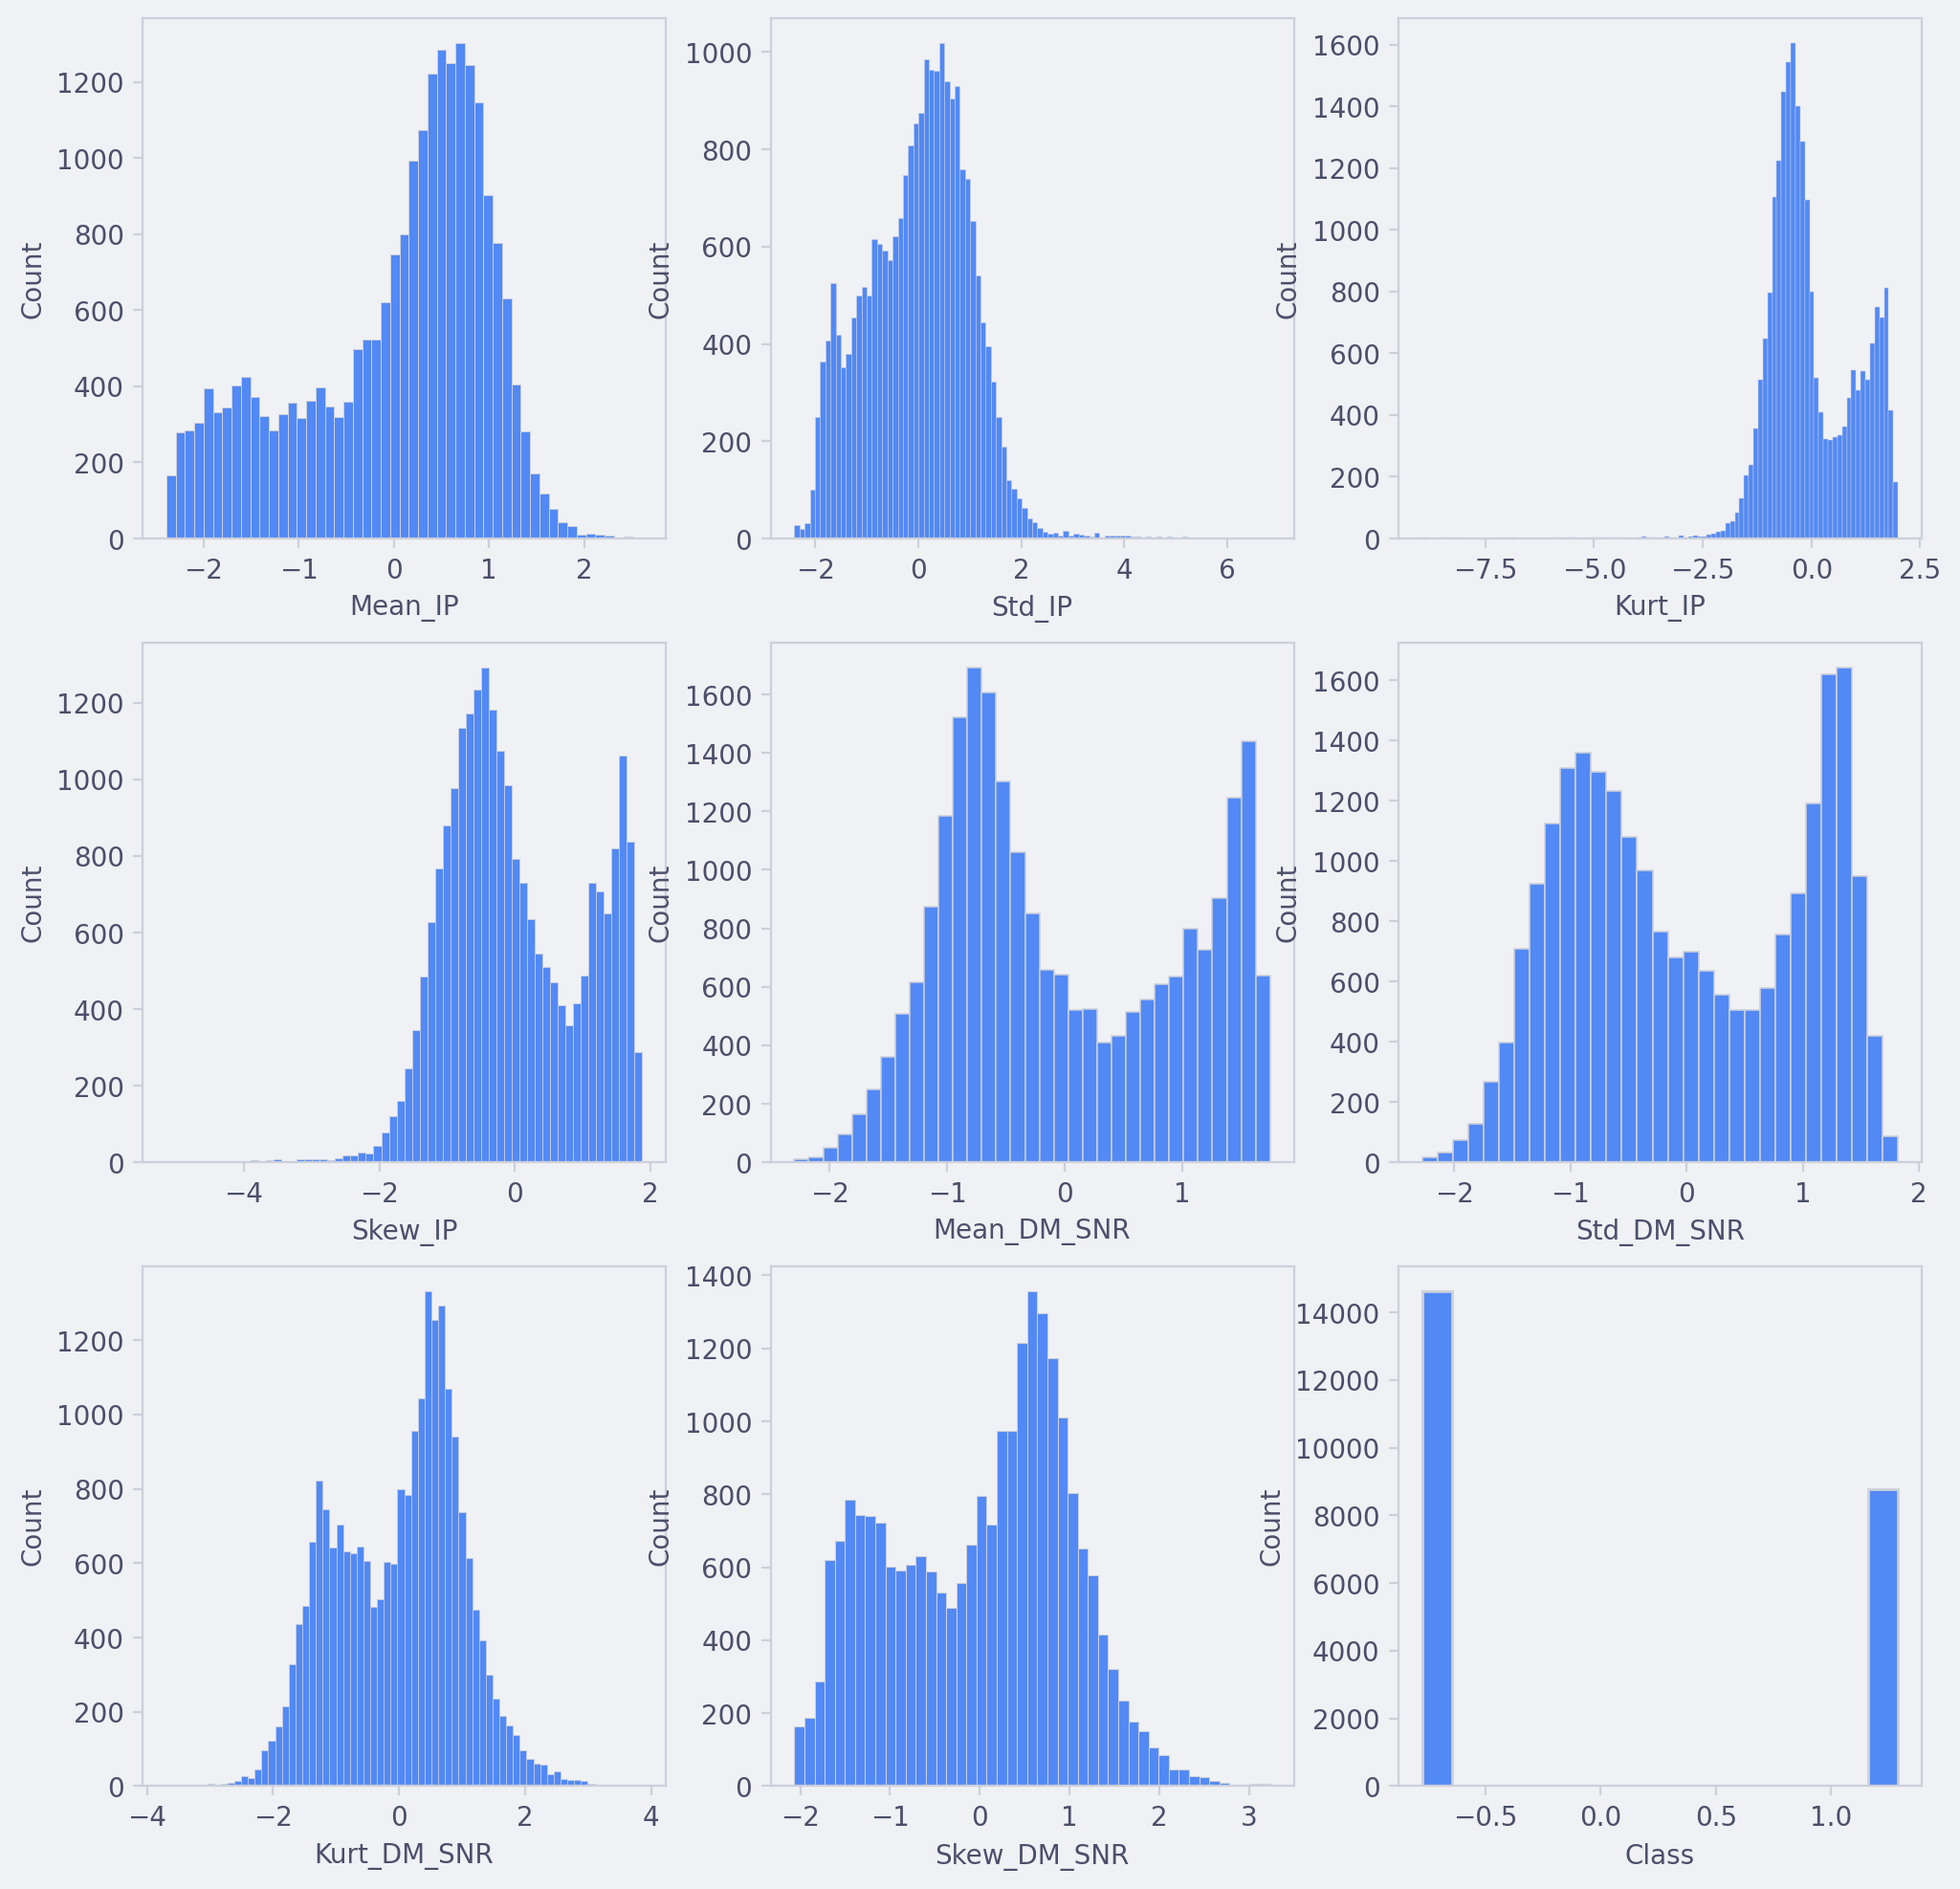

In [36]:
std_col = ['Mean_IP', 'Std_IP']

preprocessor = ColumnTransformer(transformers=[
    ('std', std_transf, std_col)
], remainder=pow_transf, 
n_jobs=-1,
verbose_feature_names_out=False)

test_check = pd.DataFrame(data=preprocessor.fit_transform(df_pulsar), columns=preprocessor.get_feature_names_out())

plt.figure(figsize=(12,12))
for _, k in enumerate(test_check.columns.to_list()):
    ax = plt.subplot(nrows, ncols, _+1)
    sns.histplot(x=test_check[k], ax=ax)

In [37]:
test_check.isna().sum()

Mean_IP        0
Std_IP         0
Kurt_IP        0
Skew_IP        0
Mean_DM_SNR    0
Std_DM_SNR     0
Kurt_DM_SNR    0
Skew_DM_SNR    0
Class          0
dtype: int64

### ML Models

In [38]:
X = df_pulsar.drop('Class', axis=1)
y = df_pulsar['Class']

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, train_size=0.85, stratify=y)
print(X_train.shape)
print(X_val.shape)


(19900, 8)
(3512, 8)


First let's evaluate which base models have a better performance with the given data, before doing any fine-tuning in the information

In [39]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression())
])

ridge_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', RidgeClassifier())
])

ada_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ada', AdaBoostClassifier())
])

bag_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('bag', BaggingClassifier())
])

etc_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('etr', ExtraTreeClassifier())
])

gbc_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gbc', GradientBoostingClassifier())
])

hgbc_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('hgbc', HistGradientBoostingClassifier())
])

rfc_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

svc_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

dtc_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dtc', DecisionTreeClassifier())
])

extra_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('extra', ExtraTreeClassifier())
])


LogisticRegression()

In [63]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score

models = [
    lr_clf, ridge_clf, ada_clf, 
    bag_clf, etc_clf, gbc_clf, 
    hgbc_clf, rfc_clf, svc_clf, 
    dtc_clf, extra_clf
    ]

models_names = ['LogisticRegression', 'RidgeClassifier', 'AdaBoostClassifier',
                'BaggingClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier',
                'HistGradientBoostingClassifier', 'RandomForestClassifier', 'SVC',
                'DecisionTreeClassifier', 'ExtraTreeClassifier']
results = {}

for i, model in zip(models_names, models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1 = np.round(f1_score(y_true=y_val, y_pred=y_pred), 3)
    acc = np.round(accuracy_score(y_true=y_val, y_pred=y_pred), 3)
    recall = np.round(recall_score(y_true=y_val, y_pred=y_pred), 3)
    roc_auc = np.round(roc_auc_score(y_true=y_val, y_score=y_pred), 3)
    results[i] = {'f1':f1, 'accuracy':acc, 'recall':recall, 'roc_auc':roc_auc}
    
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.sort_values(by='roc_auc', ascending=False)

,f1,accuracy,recall,roc_auc
RandomForestClassifier,0.967,0.976,0.955,0.971
BaggingClassifier,0.960,0.971,0.949,0.966
HistGradientBoostingClassifier,0.959,0.970,0.948,0.965
DecisionTreeClassifier,0.944,0.958,0.947,0.955
ExtraTreesClassifier,0.941,0.955,0.952,0.954
ExtraTreeClassifier,0.940,0.954,0.951,0.954
GradientBoostingClassifier,0.941,0.957,0.915,0.949
SVC,0.938,0.955,0.907,0.946
LogisticRegression,0.937,0.954,0.910,0.945
RidgeClassifier,0.935,0.953,0.897,0.942


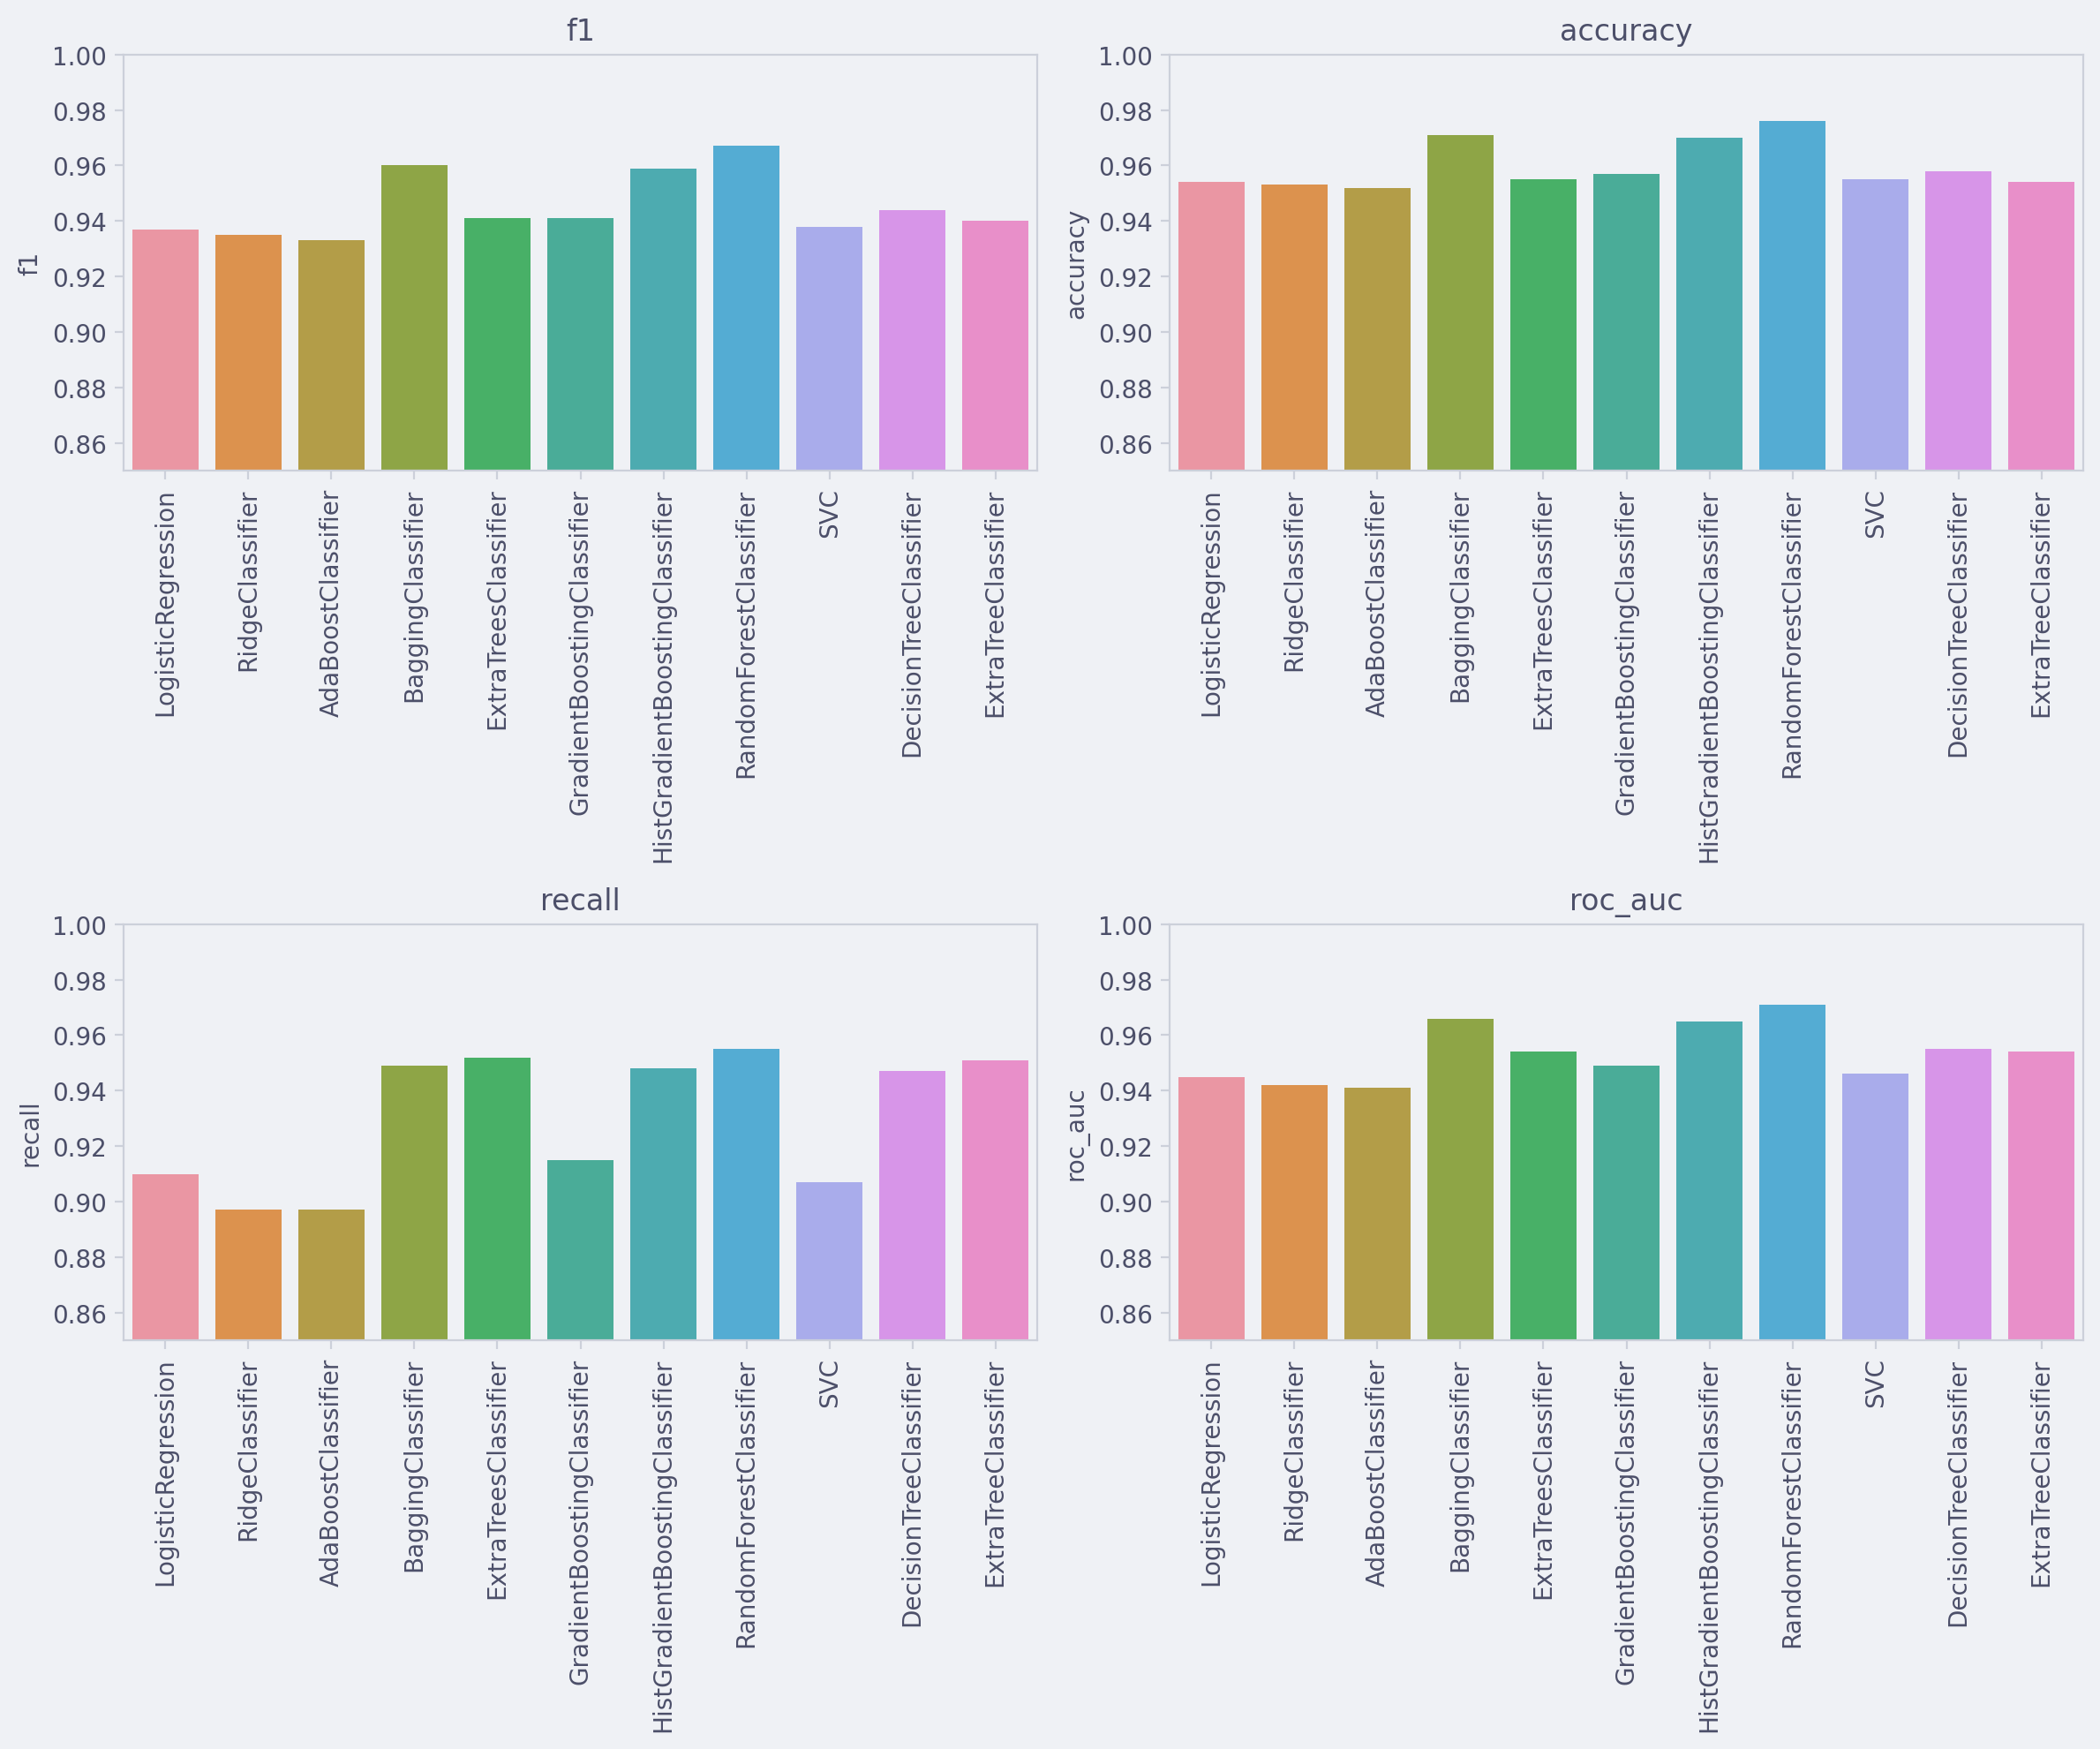

In [64]:
plt.figure(figsize=(12,10))
for a, b in enumerate(results_df.columns.to_list()):
    plt.subplot(2,2,a+1)
    sns.barplot(x=results_df.index, y=results_df[b], errorbar=None)
    plt.title(b)
    plt.xticks(rotation=90)
    plt.ylim((0.85, 1))

plt.tight_layout()

The best classifier is RandomForestClassifier, even without any adjustments in the hyperparameter. Let's do some other plots to evaluate the performance of the model in the validation set. In this case, I will plot a Confusion Matrix and a ROC-AUC Curve

In [65]:
rfc_clf.fit(X_train, y_train)
y_preds = rfc_clf.predict(X_val)

In [66]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_preds)
roc_auc = auc(fpr, tpr)


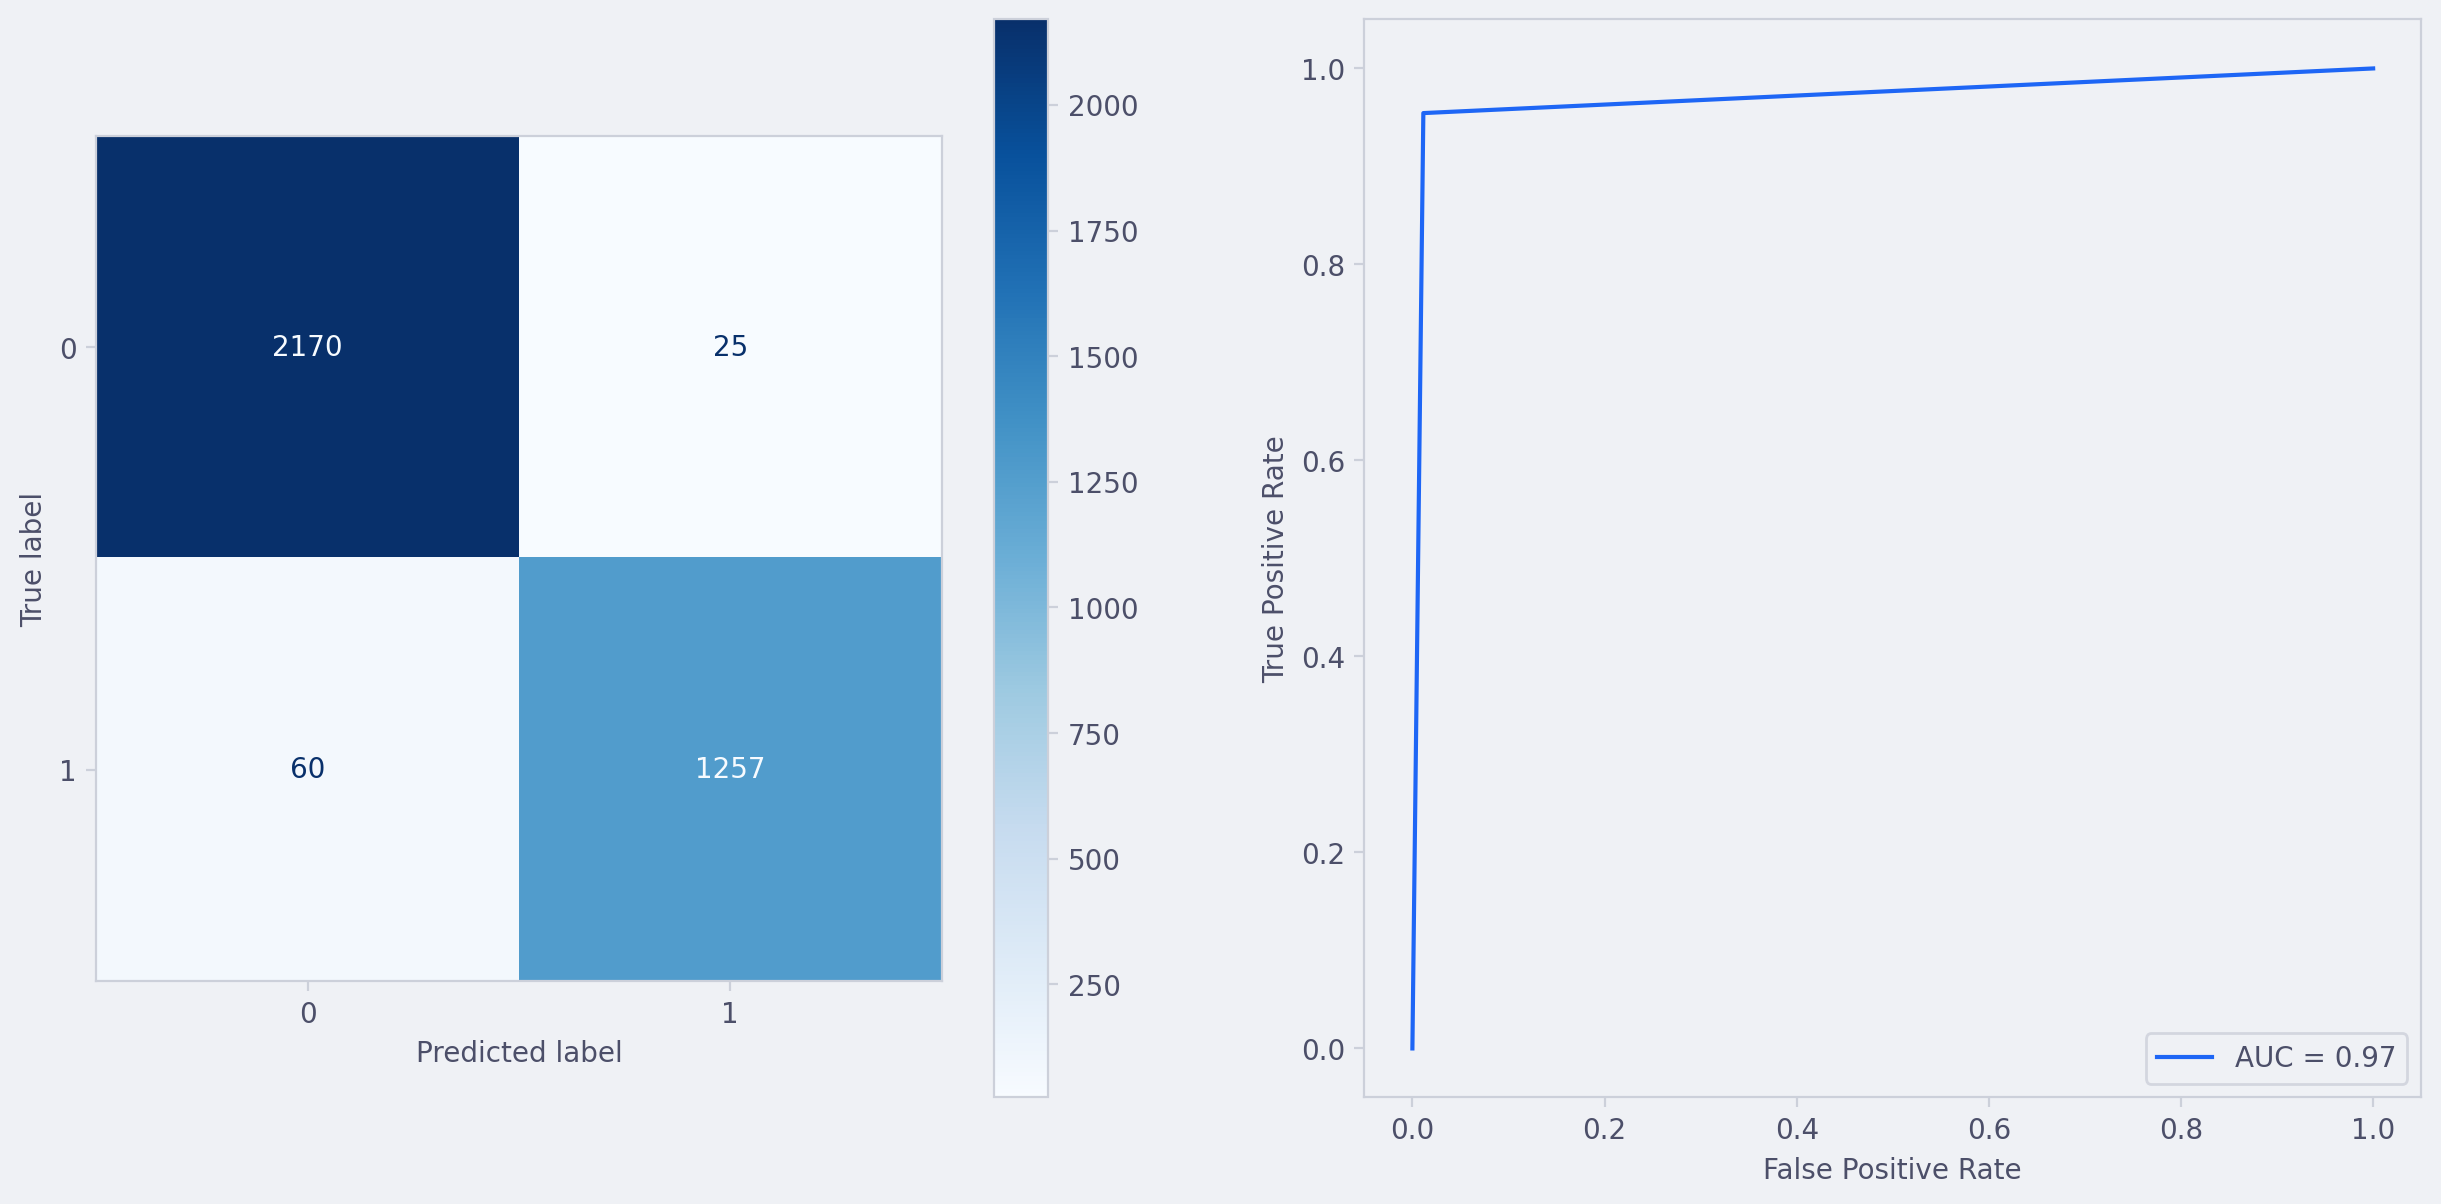

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

cm = confusion_matrix(y_true=y_val, y_pred=y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=axs[0])

disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp_roc.plot(ax=axs[1])

plt.show()

Now we evaluate in the test set

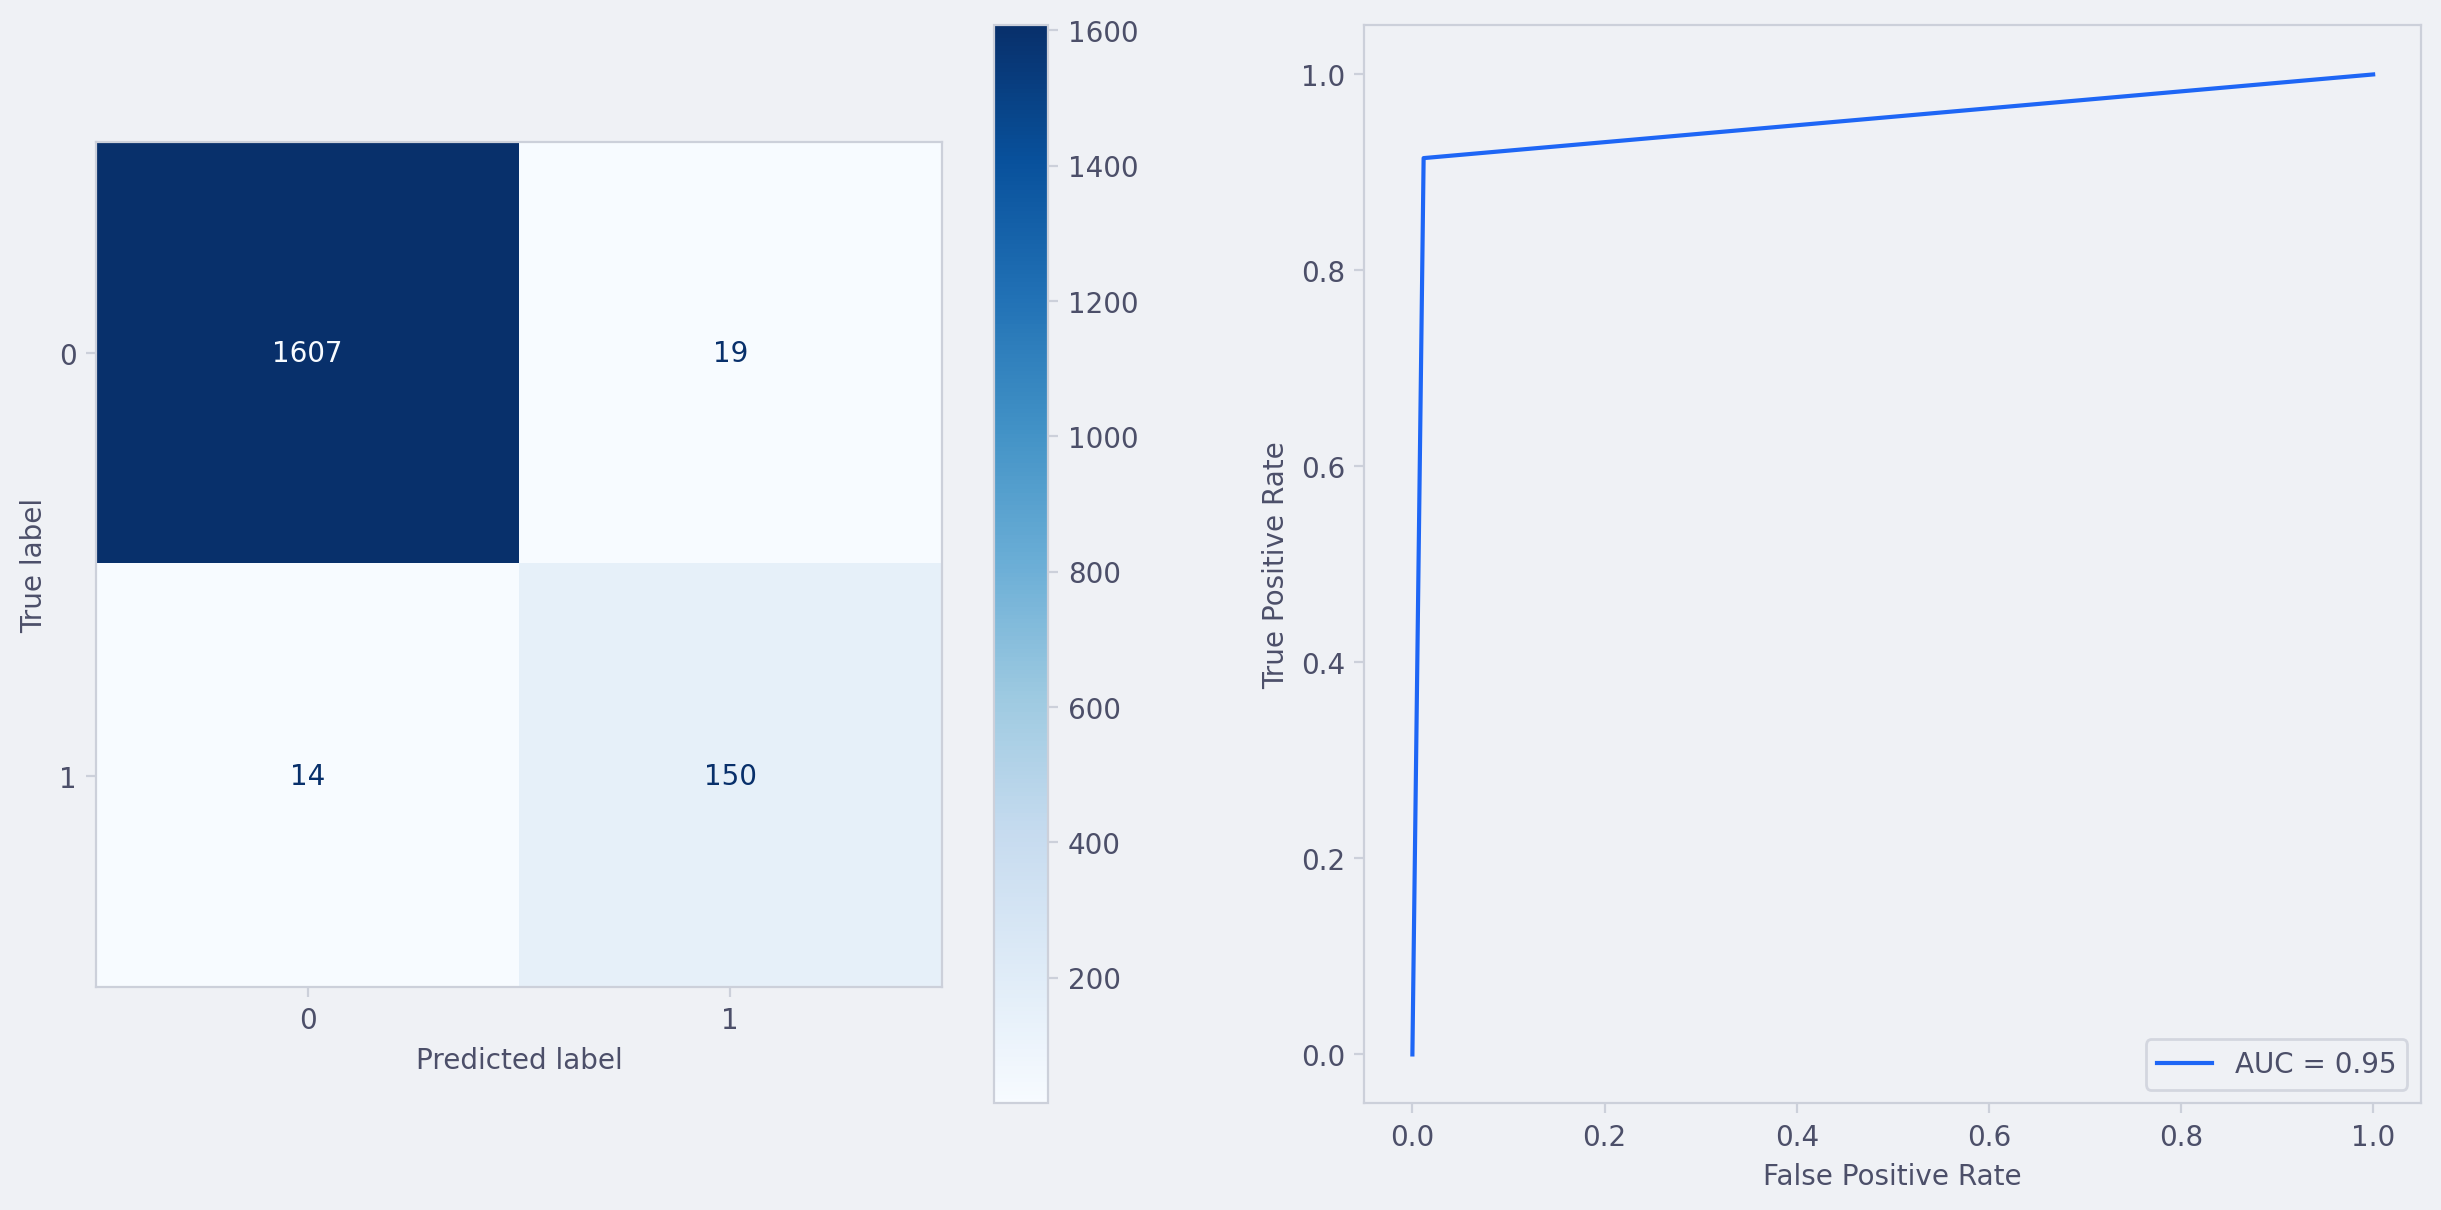

In [69]:
X_test = test.drop('Class', axis=1)
y_test = test['Class']

rfc_clf.fit(X_train, y_train)
y_preds_test = rfc_clf.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_preds_test)
roc_auc = auc(fpr, tpr)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

cm = confusion_matrix(y_true=y_test, y_pred=y_preds_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=axs[0])

disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp_roc.plot(ax=axs[1])

plt.show()

For finalising this exercise, I will plot the Classification Report for both validation and test sets

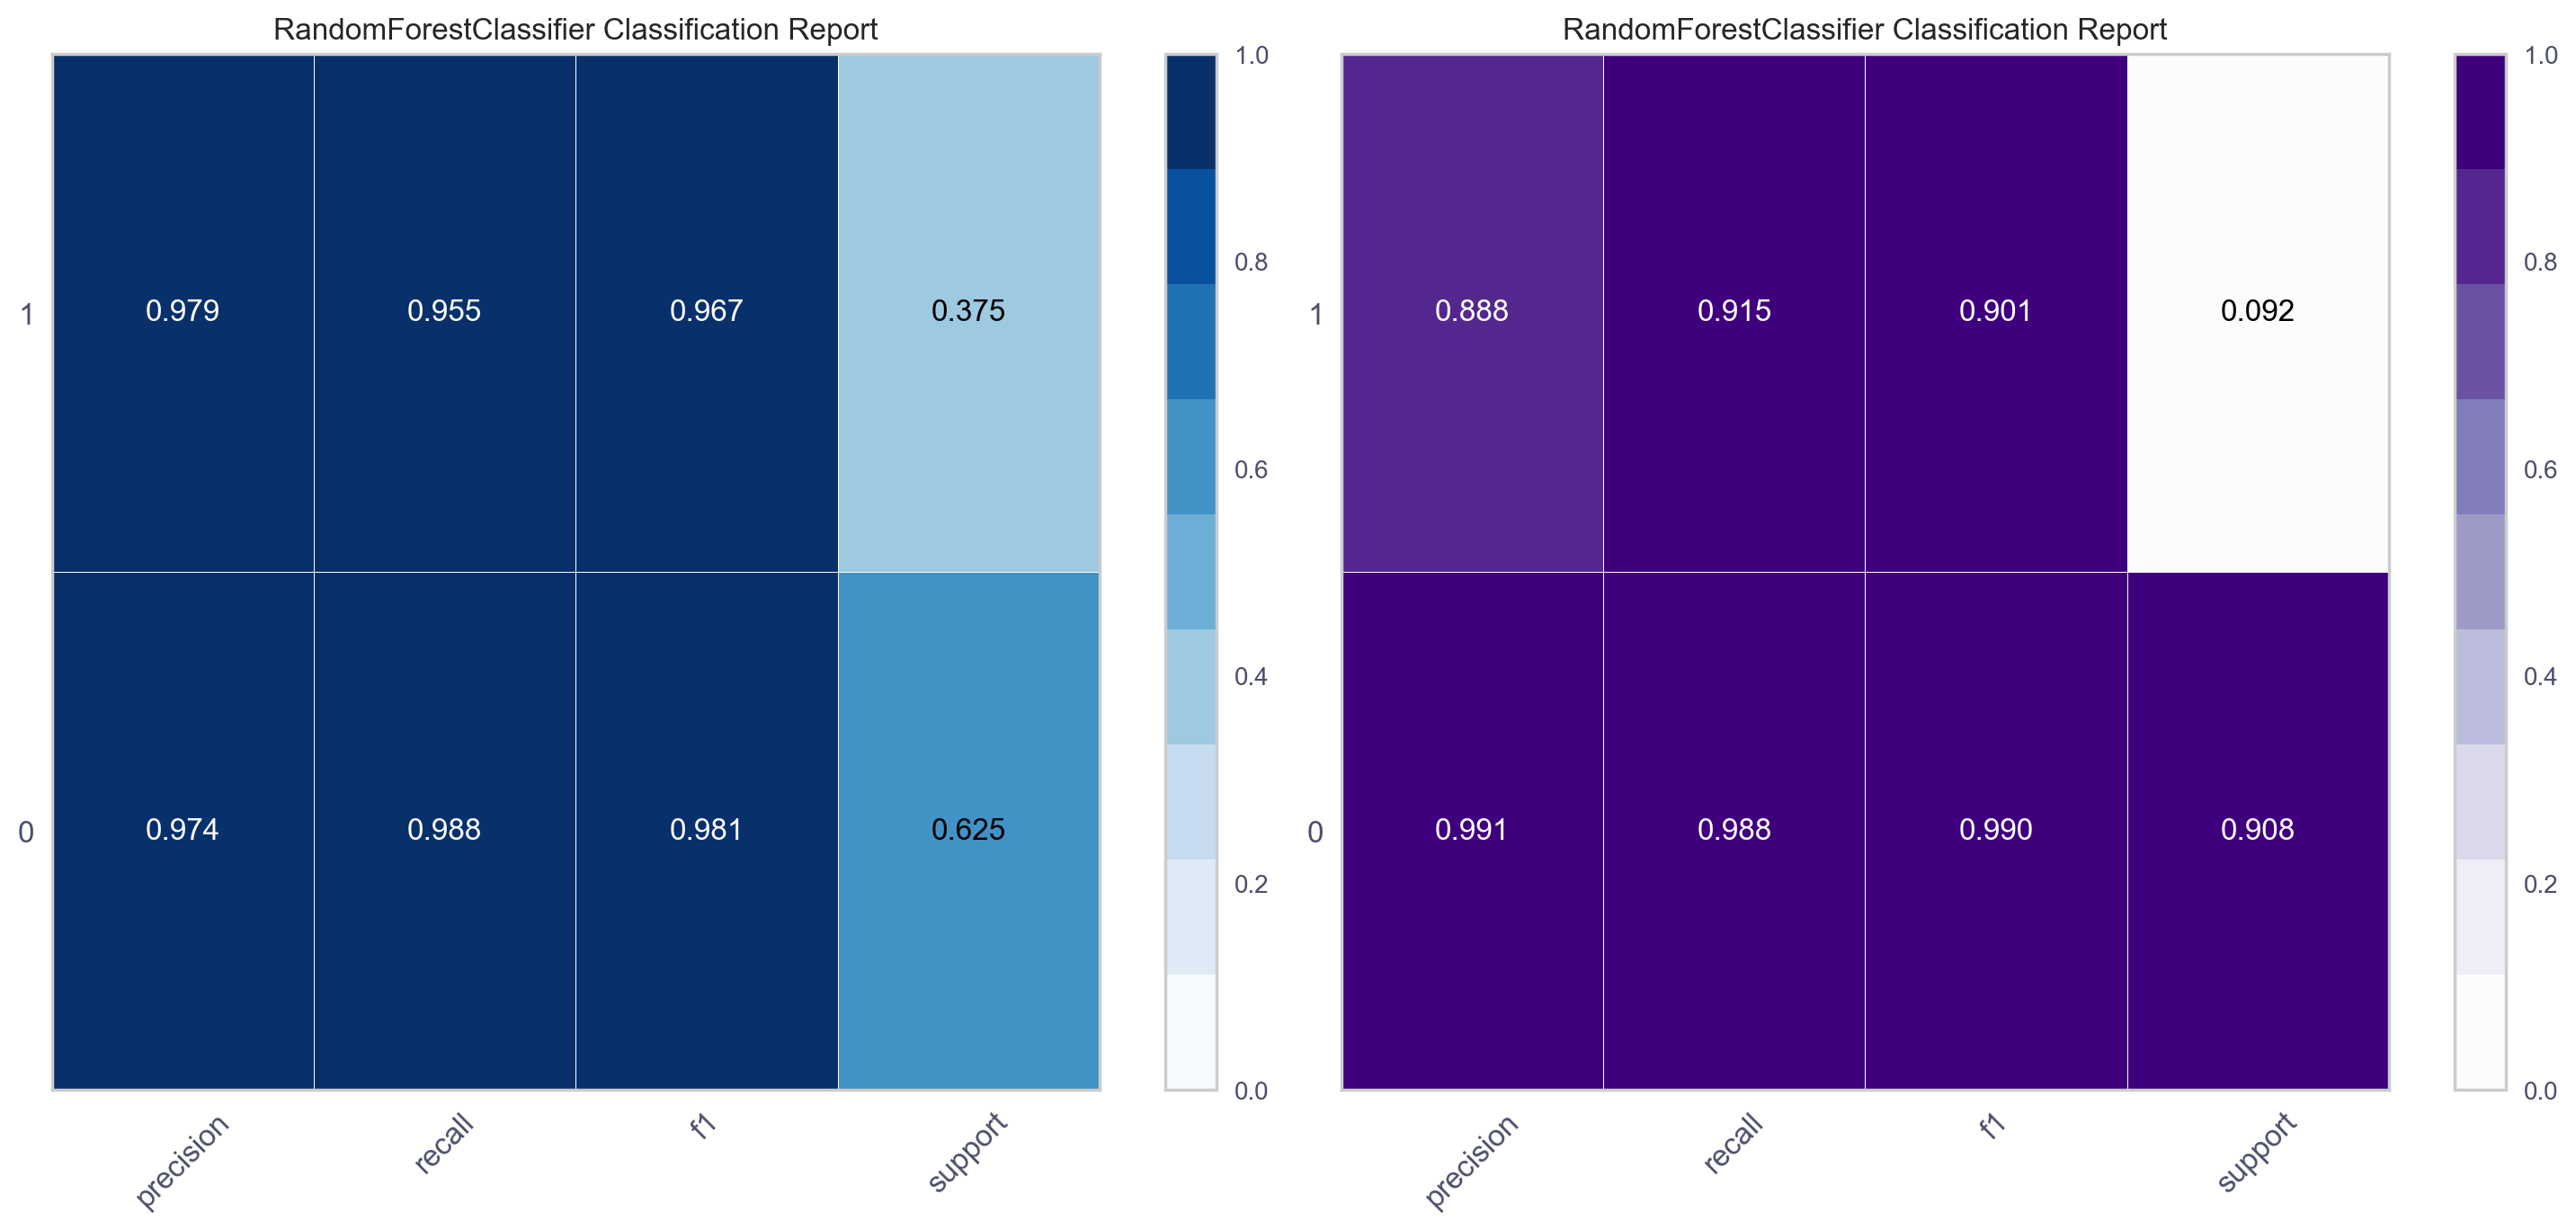

In [72]:
from yellowbrick.classifier import ClassificationReport

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

vis_val = ClassificationReport(rfc_clf, ax=axs[0], cmap='Blues', support='percent')
vis_val.fit(X_train, y_train)
vis_val.score(X_val, y_val)
vis_val.finalize()

vis_test = ClassificationReport(rfc_clf, ax=axs[1], cmap='Purples', support='percent')
vis_test.fit(X_train, y_train)
vis_test.score(X_test, y_test)
vis_test.finalize()